# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on 13 Sep 2023.

- Material: Maraging Steel 300
- Process: Robotic Laser-directed energy deposition
- Recorded data: position, veolocity, coaxial ccd features, audio feature
- Quality labels generated: keyhole pores, cracks, defect-free

### Notebook 3: ML modelling
- Using the handcrafted features from video and audio stream
- Vision features: melt pool geometric features, including width, length, moment of area, convex hull, etc.
- Audio features: spectral centroid, spectral bandwidth, flux, etc.
- __Modelling__: Once the features are ready, they can be used to train a machine learning model.
- __Evaluate__ the predictions of the validation data by calculating the f1 score and showing a confusion matrix

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier


from pprint import pprint
from scipy.interpolate import griddata
from pylab import * # For adjusting frame width only
from sklearn.preprocessing import OneHotEncoder
import sklearn.gaussian_process as gp 
import sklearn.model_selection as ms
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb

from sklearn.datasets import load_digits
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [4]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [5]:
import sys
sys.path.insert(0, '../utils')
import glob
import os
# import utils
FRAME_SIZE = 2048
HOP_LENGTH = 512

In [6]:
### Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 8))
    im_ratio = cm.shape[1]/cm.shape[0]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18, pad=12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize = 16, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth', fontsize=20, labelpad =12)
    plt.xlabel('Predicted', fontsize=20, labelpad =12)
    plt.xticks(fontsize=16,  rotation=30, ha='right')
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(orientation="vertical", pad=0.1, ticks=[0, 0.5, 1], fraction=0.045*im_ratio)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('Accuracy',fontsize=16, pad = 12)
    plt.tight_layout()

    
## Define function to get the confusion matrix and print out the plot as well
def conf_matrix(y_true, y_pred, classes=["Laser-off",'Defect-free','Cracks','Keyhole pores'] ):
    cm = confusion_matrix(y_true, y_pred)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    
    # classes = le.classes_
    print(cm)
    plot_confusion_matrix(cm_pct, classes)

In [7]:
def show_confusion_matrix(y_true, y_pred, classes=None, classes_categorical=None, normalize=None, figsize=(10, 10), 
                          dpi=600, fontsize=10, axis_fontsize=14, tick_size=12):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    
    if normalize == 'true':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.65)
    
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes_categorical, rotation=45, fontsize=tick_size, ha='left')
        plt.yticks(tick_marks, classes_categorical, fontsize=tick_size)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)
    
    ax.set_xlabel('Predicted label', fontsize=axis_fontsize)
    ax.set_ylabel('True label', fontsize=axis_fontsize)

In [76]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'ML modelling (handcrafted features)')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models")
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz_buffered')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

## Import Extracted features

In [27]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'data_audio_visual.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])
df_multimodal

sample index      audio_file_name      image_file_name   class_name  \
0                 1      sample_21_1.wav      sample_21_1.jpg    Laser-off   
1                 2      sample_21_2.wav      sample_21_2.jpg        Crack   
2                 3      sample_21_3.wav      sample_21_3.jpg        Crack   
3                 4      sample_21_4.wav      sample_21_4.jpg        Crack   
4                 5      sample_21_5.wav      sample_21_5.jpg  Defect-free   
...             ...                  ...                  ...          ...   
21156         11392  sample_23_11392.wav  sample_23_11392.jpg    Laser-off   
21157         11393  sample_23_11393.wav  sample_23_11393.jpg    Laser-off   
21158         11394  sample_23_11394.wav  sample_23_11394.jpg    Laser-off   
21159         11395  sample_23_11395.wav  sample_23_11395.jpg    Laser-off   
21160         11396  sample_23_11396.wav  sample_23_11396.jpg    Laser-off   

      class_name_v2  Layer number  Sample number         X         Y  \
0         Laser-off           1.0             21  0.136620  0.265042   
1         Defective           1.0             21  0.128219  0.275541   
2         Defective           1.0             21  0.126358  0.276802   
3         Defective           1.0             21  0.124890  0.278469   
4       Defect-free           1.0             21  0.124157  0.278818   
...             ...           ...            ...       ...       ...   
21156     Laser-off          50.0             23       NaN       NaN   
21157     Laser-off          50.0             23       NaN       NaN   
21158     Laser-off          50.0             23       NaN       NaN   
21159     Laser-off          50.0             23       NaN       NaN   
21160     Laser-off          50.0             23       NaN       NaN   

              Z  ...      nu11      nu02      nu30      nu21      nu12  \
0      9.588183  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1      3.966295  ...  0.000000  0.062337  0.000000  0.000000  0.000000   
2      2.995122  ...  0.000000  0.062337  0.000000  0.000000  0.000000   
3      2.108443  ... -0.008049  0.062216  0.001940 -0.002304 -0.001599   
4      1.804407  ... -0.009879  0.065910  0.001738 -0.003345 -0.000898   
...         ...  ...       ...       ...       ...       ...       ...   
21156       NaN  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
21157       NaN  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
21158       NaN  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
21159       NaN  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
21160       NaN  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

           nu03    center_x    center_y  contour_area  contour_length  
0      0.000000    0.000000    0.000000           0.0        0.000000  
1      0.000000  319.500000  239.000000      305442.0     2234.000000  
2      0.000000  319.500000  239.000000      305442.0     2234.000000  
3      0.000891  307.440996  230.264496      291865.5     2279.781744  
4      0.001388  296.636877  229.109962      281970.0     2407.847760  
...         ...         ...         ...           ...             ...  
21156  0.000000    0.000000    0.000000           0.0        0.000000  
21157  0.000000    0.000000    0.000000           0.0        0.000000  
21158  0.000000    0.000000    0.000000           0.0        0.000000  
21159  0.000000    0.000000    0.000000           0.0        0.000000  
21160  0.000000    0.000000    0.000000           0.0        0.000000  

[18601 rows x 129 columns]

In [28]:
df_multimodal['class_name'].unique()

['Laser-off', 'Crack', 'Defect-free', 'Keyhole pores']
Categories (4, object): ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']

In [29]:
print (df_multimodal.columns)

Index(['sample index', 'audio_file_name', 'image_file_name', 'class_name',
       'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z',
       ...
       'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03', 'center_x', 'center_y',
       'contour_area', 'contour_length'],
      dtype='object', length=129)


## Constructing labels and input features for training the models

In [30]:
# Label = df_multimodal['class_name'].to_list()
y = df_multimodal['class_name'].to_list()

# Drop non-feature columns and store the result in a variable
X_all = df_multimodal.drop(columns=['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                                    'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']).to_numpy()


X_audio = df_multimodal[['rms_energy', 'amplitude_envelope_mean',
                           'amplitude_envelope_std', 'zero_crossing_rate', 'dynamic_complexity',
                           'loudness', 'loudness_vickers', 'spectral_centroid_mean',
                           'spectral_centroid_std', 'spectral_complexity_mean',
                           'spectral_complexity_std', 'spectral_contrast_0_mean',
                           'spectral_contrast_0_std', 'spectral_contrast_1_mean',
                           'spectral_contrast_1_std', 'spectral_contrast_2_mean',
                           'spectral_contrast_2_std', 'spectral_contrast_3_mean',
                           'spectral_contrast_3_std', 'spectral_contrast_4_mean',
                           'spectral_contrast_4_std', 'spectral_contrast_5_mean',
                           'spectral_contrast_5_std', 'spectral_valley_0_mean',
                           'spectral_valley_0_std', 'spectral_valley_1_mean',
                           'spectral_valley_1_std', 'spectral_valley_2_mean',
                           'spectral_valley_2_std', 'spectral_valley_3_mean',
                           'spectral_valley_3_std', 'spectral_valley_4_mean',
                           'spectral_valley_4_std', 'spectral_valley_5_mean',
                           'spectral_valley_5_std', 'spectral_decrease_mean',
                           'spectral_decrease_std', 'spectral_energy_mean', 'spectral_energy_std',
                           'spectral_energy_band_ratio_mean', 'spectral_energy_band_ratio_std',
                           'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_flux_mean',
                           'spectral_flux_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
                           'spectral_strong_peak_mean', 'spectral_strong_peak_std',
                           'spectral_variance_mean', 'spectral_variance_std',
                           'spectral_skewness_mean', 'spectral_skewness_std',
                           'spectral_kurtosis_mean', 'spectral_kurtosis_std',
                           'spectral_crest_factor_mean', 'spectral_crest_factor_std',
                           'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
                           'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
                           'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
                           'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
                           'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std',
                           'mfcc_12_mean', 'mfcc_12_std']].to_numpy()
                     

X_vision = df_multimodal[['max_contour_area', 'rectangle_angle',
                          'rectangle_width', 'rectangle_height', 'ellipse_angle', 'ellipse_width',
                          'ellipse_height', 'max_hull', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02',
                          'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21',
                          'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03',
                          'center_x', 'center_y', 'contour_area', 'contour_length']].to_numpy()

# ML Modelling 

In [31]:
all_accuracy_mean_list = []
all_accuracy_std_list = []
vision_accuracy_mean_list = []
vision_accuracy_std_list = []
acoustic_accuracy_mean_list = []
acoustic_accuracy_std_list = []

all_auc_mean = []
all_auc_std = []
vision_auc_mean = []
vision_auc_std = []
acoustic_auc_mean = []
acoustic_auc_std = []

import time

### Train val test split
- Train 80%, Val 10%, Test 10%

In [35]:
# First split: Separate out the test set (10% for testing)
test_size = 0.10

X_all_train, X_all_test, Y_all_train, Y_all_test = train_test_split(
    X_all, y, test_size=test_size, random_state=0, stratify=df_multimodal.class_name, shuffle=True)

X_audio_train, X_audio_test, Y_audio_train, Y_audio_test = train_test_split(
    X_audio, y, test_size=test_size, random_state=0, stratify=df_multimodal.class_name, shuffle=True)

X_vision_train, X_vision_test, Y_vision_train, Y_vision_test = train_test_split(
    X_vision, y, test_size=test_size, random_state=0, stratify=df_multimodal.class_name, shuffle=True)

In [36]:
# Second split: Separate out the validation set from the training set (which will be 10% of the remaining 90%, i.e., 9% of the original)
val_size = 0.1111  # which is 10% of 90%

X_all_train, X_all_val, Y_all_train, Y_all_val = train_test_split(
    X_all_train, Y_all_train, test_size=val_size, random_state=0, stratify=Y_all_train, shuffle=True)

X_audio_train, X_audio_val, Y_audio_train, Y_audio_val = train_test_split(
    X_audio_train, Y_audio_train, test_size=val_size, random_state=0, stratify=Y_audio_train, shuffle=True)

X_vision_train, X_vision_val, Y_vision_train, Y_vision_val = train_test_split(
    X_vision_train, Y_vision_train, test_size=val_size, random_state=0, stratify=Y_vision_train, shuffle=True)


In [37]:
# Label encoding
le = LabelEncoder()
le.fit(y)

Y_all_train_encoded = le.transform(Y_all_train)
Y_all_val_encoded = le.transform(Y_all_val)
Y_all_test_encoded = le.transform(Y_all_test)

Y_audio_train_encoded = le.transform(Y_audio_train)
Y_audio_val_encoded = le.transform(Y_audio_val)
Y_audio_test_encoded = le.transform(Y_audio_test)

Y_vision_train_encoded = le.transform(Y_vision_train)
Y_vision_val_encoded = le.transform(Y_vision_val)
Y_vision_test_encoded = le.transform(Y_vision_test)

In [38]:
print(f"Training set size: {len(Y_all_train)}")
print(f"Validation set size: {len(Y_all_val)}")
print(f"Testing set size: {len(Y_all_test)}")

Training set size: 14880
Validation set size: 1860
Testing set size: 1861


In [39]:
le.classes_

array(['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off'], dtype='<U13')

In [40]:
Y_all_train_encoded

array([0, 1, 1, ..., 1, 1, 1])

### Compute class weight

This is for treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only).

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [43]:
class_weights_all = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_all_train),
                                                 y = Y_all_train)

class_weights_all_encoded = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_all_train_encoded),
                                                 y = Y_all_train_encoded)

class_weights_audio = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_audio_train),
                                                 y = Y_audio_train)
class_weights_vision = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_vision_train),
                                                 y = Y_vision_train)

class_names = (le.classes_).tolist()
print(f"class weights: {class_weights_all}")
print(f"class weights encoded: {class_weights_all_encoded}")
print(f"class        : {class_names}")

class weights: [5.40697674 0.64910138 1.18132741 0.7003012 ]
class weights encoded: [5.40697674 0.64910138 1.18132741 0.7003012 ]
class        : ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']


In [44]:
print(f"class weights: {class_weights_all}")
print(f"class        : {np.unique(le.inverse_transform(Y_all_train_encoded))}")

class weights: [5.40697674 0.64910138 1.18132741 0.7003012 ]
class        : ['Crack' 'Defect-free' 'Keyhole pores' 'Laser-off']


### Data standarization

In [45]:
# For "all" modality
scaler_all = preprocessing.StandardScaler()
X_all_train_transformed = scaler_all.fit_transform(X_all_train)
X_all_val_transformed = scaler_all.transform(X_all_val)
X_all_test_transformed = scaler_all.transform(X_all_test)

# For "audio" modality
scaler_audio = preprocessing.StandardScaler()
X_audio_train_transformed = scaler_audio.fit_transform(X_audio_train)
X_audio_val_transformed = scaler_audio.transform(X_audio_val)
X_audio_test_transformed = scaler_audio.transform(X_audio_test)

# For "vision" modality
scaler_vision = preprocessing.StandardScaler()
X_vision_train_transformed = scaler_vision.fit_transform(X_vision_train)
X_vision_val_transformed = scaler_vision.transform(X_vision_val)
X_vision_test_transformed = scaler_vision.transform(X_vision_test)

In [46]:
import pickle

# Save the scaler objects
with open('StandardScaler_all.pkl', 'wb') as file:
    pickle.dump(scaler_all, file)

with open('StandardScaler_audio.pkl', 'wb') as file:
    pickle.dump(scaler_audio, file)
    
with open('StandardScaler_vision.pkl', 'wb') as file:
    pickle.dump(scaler_vision, file)

## ML training, with hyperparameter optimization, cross-validation

Predicts the melt pool temperature based on features of the other sensing models, iterating over the algorithms:

- K nearest neighbor classification: 'KNN'

- Decision Tree classification: 'DT'

- Adaptive Boosting classification: 'AdaBoost'

- Random Forests classification 'RF'
  
- Gaussian Process classification 'GPR'
  
- Support Vector classification 'SVR'
  
- Gradient Boosting classification 'GB'
  
- Nerual Network classification 'NN'

In [47]:
# class_weight_computed = {
#     class_names[0]: class_weights_all[0], 
#     class_names[1]: class_weights_all[1], 
#     class_names[2]: class_weights_all[2], 
#     class_names[3]: class_weights_all[3],
# }
# print (class_weight_computed)

In [48]:
class_weight_computed = {
    0: class_weights_all[0], 
    1: class_weights_all[1], 
    2: class_weights_all[2], 
    3: class_weights_all[3],
}
print (class_weight_computed)

{0: 5.406976744186046, 1: 0.6491013784679811, 2: 1.1813274055255636, 3: 0.7003012048192772}


## Step1: Hyperparameter tuning: RandomizedSearchCV

- Considering the feature space and the data volume, RandomizedSearchCV is much more faster to do.
- Get a initial result for hyperparameter values

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import numpy as np

n_iter_search = 20

# -------------------------1 For KNN:-----------------------
knn_distributions = {
    'n_neighbors': sp_randint(1, 50),
    'weights': ['uniform', 'distance']
}
knn_search = RandomizedSearchCV(neighbors.KNeighborsClassifier(), knn_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# ------------------2 For Decision Trees:-----------------------
dt_distributions = {
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_depth': sp_randint(1, 50),
    'ccp_alpha': uniform(0.0, 0.05)
}
dt_search = RandomizedSearchCV(tree.DecisionTreeClassifier(class_weight=class_weight_computed), dt_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# ------------- 3 for Logistic Regression:----------
lr_distributions = {
    'solver': ['lbfgs', 'sag'],
    'penalty': ['l2'],
    'C': uniform(0.01, 10),
    'max_iter': sp_randint(1000, 10000)
}
lr_search = RandomizedSearchCV(LogisticRegression(class_weight=class_weight_computed), lr_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ---------------4 For Random Forest:-------------------
rf_distributions = {
    'n_estimators': sp_randint(1, 500),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_depth': sp_randint(1, 100),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(class_weight=class_weight_computed), rf_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ------------- 5 for BalancedRandomForestClassifier -----
brf_distributions = {
    'n_estimators': sp_randint(1, 500),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_depth': sp_randint(1, 50),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
brf_search = RandomizedSearchCV(BalancedRandomForestClassifier(), brf_distributions, 
                                n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ------------- 6 for RUSBoostClassifier---------------
rusboost_distributions = {
    'n_estimators': sp_randint(1, 500),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
}
rusboost_search = RandomizedSearchCV(RUSBoostClassifier(), rusboost_distributions,
                                     n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ------------------7 For AdaBoost:----------------------
ada_distributions = {
    'n_estimators': sp_randint(1, 500),
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': uniform(0.5, 1.5)
}
ada_search = RandomizedSearchCV(AdaBoostClassifier(), ada_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ------------8 For Gaussian Process:------------
gp_distributions = {
    'kernel': [1.0 * RBF(1.0)]
}
gp_search = RandomizedSearchCV(GaussianProcessClassifier(), gp_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ------------ 9 For Neural Network:-----------
nn_distributions = {
    'hidden_layer_sizes': [(sp_randint(16, 256).rvs(), sp_randint(16, 256).rvs(), sp_randint(16, 256).rvs()) for _ in range(10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': uniform(0.001, 0.1),
    'learning_rate': ['adaptive'],
    'max_iter': sp_randint(1000, 20000),
    'early_stopping': [True],
    'validation_fraction': [0.1]
}
nn_search = RandomizedSearchCV(MLPClassifier(), nn_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


## ------------ 10 For Xboost:-----------
xgb_distributions = {
    'n_estimators': sp_randint(50, 500),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'max_depth': list(range(1, 50)),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': list(range(1, 20)),
    'gamma': uniform(0, 2)
}
xgb_search = RandomizedSearchCV(xgb.XGBClassifier(objective='multi:softmax'), xgb_distributions, 
                                n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42
)


## ------------ 11 for LightGBM -----------
lgb_distributions = {
    'n_estimators': sp_randint(50, 500),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'num_leaves': sp_randint(20, 150),
    'max_depth': sp_randint(1, 50),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 20),
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(0, 2),
}

lgb_search = RandomizedSearchCV(lgb.LGBMClassifier(objective='multiclass', metric='multi_logloss'), 
                                lgb_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ----------------12 For Support Vector Machine:-----------------
svm_distributions = {
    'C': uniform(0.1, 1000),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': sp_randint(1, 10),
    'gamma': uniform(1e-4, 1e-1)
}
svm_search = RandomizedSearchCV(SVC(class_weight=class_weight_computed), svm_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


# ---------  13 For GradientBoostingClassifier:---------------------
gboost_distributions = {
    'n_estimators': sp_randint(1, 500),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.5, 0.5),
    'max_depth': sp_randint(1, 50),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'n_iter_no_change': [10],
    'tol': [1e-4]
}
gboost_search = RandomizedSearchCV(GradientBoostingClassifier(), gboost_distributions, n_iter=n_iter_search, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

In [50]:
len(X_all_train_transformed)*0.1

1488.0

### RandomizedSearchCV Initialization & Model Fitting (ALL features)

In [54]:
from scipy.stats import randint, uniform


# 1. KNN
knn_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 2. Decision Tree
dt_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 3. Logistic Regression:
lr_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 4. Random Forest
rf_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 5. Balanced Forest
brf_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 6. RUSBoost
rusboost_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 7. AdaBoost 
ada_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 8. Gaussian Process 
# Sample a subset of your data for faster training
n_samples = 1488  # 10% of the total data
X_sample, y_sample = resample(X_all_train_transformed, Y_all_train_encoded, n_samples=n_samples, random_state=42)
gp_search.fit(X_sample, y_sample)

# 9. Neural Network:
nn_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 10. XGBoost:
xgb_search.fit(X_sample, y_sample)

# 11. LightGBM
lgb_search.fit(X_sample, y_sample)

# 12. SVM:
svm_search.fit(X_all_train_transformed, Y_all_train_encoded)

# 13. GradientBoostingClassifier
gboost_search.fit(X_all_train_transformed, Y_all_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to

[CV 5/5] END ..n_neighbors=39, weights=distance;, score=0.315 total time=   0.3s
[CV 1/5] END ...n_neighbors=21, weights=uniform;, score=0.923 total time=   0.4s
[CV 5/5] END ...n_neighbors=19, weights=uniform;, score=0.915 total time=   0.4s
[CV 3/5] END ...n_neighbors=24, weights=uniform;, score=0.917 total time=   0.4s
[CV 5/5] END ..n_neighbors=36, weights=distance;, score=0.315 total time=   0.4s
[CV 2/5] END ...n_neighbors=22, weights=uniform;, score=0.916 total time=   0.5s
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.316 total time=   0.3s
[CV 3/5] END ..n_neighbors=38, weights=distance;, score=0.158 total time=   0.4s
[CV 5/5] END ...n_neighbors=21, weights=uniform;, score=0.917 total time=   0.5s
[CV 4/5] END ...n_neighbors=22, weights=uniform;, score=0.919 total time=   0.5s
[CV 3/5] END ...n_neighbors=49, weights=uniform;, score=0.903 total time=   0.4s
[CV 1/5] END ..n_neighbors=28, weights=distance;, score=0.348 total time=   0.5s
[CV 5/5] END ccp_alpha=0.018

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to

[CV 1/5] END ...n_neighbors=29, weights=uniform;, score=0.919 total time=   0.4s
[CV 3/5] END ...n_neighbors=19, weights=uniform;, score=0.917 total time=   0.4s
[CV 1/5] END ...n_neighbors=24, weights=uniform;, score=0.920 total time=   0.4s
[CV 3/5] END ..n_neighbors=36, weights=distance;, score=0.159 total time=   0.3s
[CV 3/5] END ...n_neighbors=24, weights=uniform;, score=0.917 total time=   0.4s
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.346 total time=   0.4s
[CV 5/5] END ..n_neighbors=44, weights=distance;, score=0.314 total time=   0.6s
[CV 4/5] END ...n_neighbors=21, weights=uniform;, score=0.919 total time=   0.3s
[CV 1/5] END ...n_neighbors=22, weights=uniform;, score=0.920 total time=   0.5s
[CV 4/5] END ...n_neighbors=44, weights=uniform;, score=0.908 total time=   0.6s
[CV 2/5] END ..n_neighbors=42, weights=distance;, score=0.160 total time=   0.4s
[CV 2/5] END ccp_alpha=0.018727005942368126, max_depth=29, min_samples_leaf=15, min_samples_split=12;, score=

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to

[CV 2/5] END ..n_neighbors=39, weights=distance;, score=0.160 total time=   0.3s
[CV 1/5] END ..n_neighbors=43, weights=distance;, score=0.346 total time=   0.4s
[CV 4/5] END ...n_neighbors=21, weights=uniform;, score=0.919 total time=   0.4s
[CV 5/5] END ...n_neighbors=11, weights=uniform;, score=0.919 total time=   0.4s
[CV 1/5] END ..n_neighbors=36, weights=distance;, score=0.346 total time=   0.4s
[CV 4/5] END ...n_neighbors=24, weights=uniform;, score=0.917 total time=   0.4s
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.160 total time=   0.3s
[CV 3/5] END ..n_neighbors=44, weights=distance;, score=0.158 total time=   0.4s
[CV 1/5] END ...n_neighbors=21, weights=uniform;, score=0.923 total time=   0.3s
[CV 2/5] END ..n_neighbors=12, weights=distance;, score=0.161 total time=   0.2s
[CV 3/5] END ...n_neighbors=22, weights=uniform;, score=0.917 total time=   0.4s
[CV 5/5] END ...n_neighbors=44, weights=uniform;, score=0.903 total time=   0.5s
[CV 1/5] END ..n_neighbors=4

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END ...n_neighbors=29, weights=uniform;, score=0.912 total time=   0.3s
[CV 3/5] END ..n_neighbors=43, weights=distance;, score=0.158 total time=   0.4s
[CV 3/5] END ...n_neighbors=21, weights=uniform;, score=0.917 total time=   0.4s
[CV 2/5] END ...n_neighbors=11, weights=uniform;, score=0.918 total time=   0.3s
[CV 4/5] END ...n_neighbors=24, weights=uniform;, score=0.917 total time=   0.4s
[CV 2/5] END ...n_neighbors=24, weights=uniform;, score=0.916 total time=   0.4s
[CV 4/5] END ...n_neighbors=22, weights=uniform;, score=0.919 total time=   0.4s
[CV 1/5] END ..n_neighbors=44, weights=distance;, score=0.346 total time=   0.4s
[CV 4/5] END ..n_neighbors=38, weights=distance;, score=0.133 total time=   0.5s
[CV 3/5] END ..n_neighbors=12, weights=distance;, score=0.161 total time=   0.4s
[CV 1/5] END ...n_neighbors=44, weights=uniform;, score=0.915 total time=   0.4s
[CV 4/5] END ...n_neighbors=49, weights=uniform

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=242;, score=0.891 total time=   2.7s
[CV 3/5] END bootstrap=True, max_depth=39, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=242;, score=0.888 total time=   2.6s
[CV 1/5] END bootstrap=False, max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=444;, score=0.895 total time=   5.3s
[CV 4/5] END bootstrap=False, max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=444;, score=0.888 total time=   5.5s
[CV 2/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=310;, score=0.888 total time=   3.2s
[CV 5/5] END bootstrap=False, max_depth=6, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=310;, score=0.879 total time=   3.2s
[CV 4/5] END boot

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f35d1640130>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f35d1c76c10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discr...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f35d1652880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f35d757b6a0>,
                                        'n_iter_no_change': [10],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f35d1644b20>,
                                        'tol': [0.0001]},
                   random_state=42, scoring='accuracy', verbose=3)

### Best hyperparameters of each models

In [57]:
# 1
print("Best parameters for KNN: ", knn_search.best_params_)
print("Best cross-validation score for KNN: {:.2f}\n".format(knn_search.best_score_))

# 2
print("Best parameters for DT: ", dt_search.best_params_)
print("Best cross-validation score for DT: {:.2f}\n".format(dt_search.best_score_))

# 3
print("Best parameters for LR: ", lr_search.best_params_)
print("Best cross-validation score for LR: {:.2f}\n".format(lr_search.best_score_))

# 4
print("Best parameters for RF: ", rf_search.best_params_)
print("Best cross-validation score for RF: {:.2f}\n".format(rf_search.best_score_))

# 5
print("Best parameters for BalancedRandomForestClassifier: ", brf_search.best_params_)
print("Best cross-validation score for BalancedRandomForestClassifier: {:.2f}\n".format(brf_search.best_score_))

# 6
print("Best parameters for RUSBoostClassifier: ", rusboost_search.best_params_)
print("Best cross-validation score for RUSBoostClassifier: {:.2f}\n".format(rusboost_search.best_score_))

# 7 
print("Best parameters for Ada: ", ada_search.best_params_)
print("Best cross-validation score for Ada: {:.2f}\n".format(ada_search.best_score_))

# # 8
# print("Best parameters for GP: ", gp_search.best_params_)
# print("Best cross-validation score for GP: {:.2f}\n".format(gp_search.best_score_))

# 9
print("Best parameters for NN: ", nn_search.best_params_)
print("Best cross-validation score for NN: {:.2f}\n".format(nn_search.best_score_))

# 10
print("Best parameters for XGBoost: ", xgb_search.best_params_)
print("Best cross-validation score for XGBoost: {:.2f}\n".format(xgb_search.best_score_))

# 11
print("Best parameters for LightGBM: ", lgb_search.best_params_)
print("Best cross-validation score for LightGBM: {:.2f}\n".format(lgb_search.best_score_))

# 12
print("Best parameters for SVM: ", svm_search.best_params_)
print("Best cross-validation score for SVM: {:.2f}\n".format(svm_search.best_score_))

# 13. GradientBoostingClassifier
print("Best parameters for GB: ", gboost_search.best_params_)
print("Best cross-validation score for GB: {:.2f}\n".format(gboost_search.best_score_))

Best parameters for KNN:  {'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score for KNN: 0.92

Best parameters for DT:  {'ccp_alpha': 3.893829205071642e-05, 'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 13}
Best cross-validation score for DT: 0.88

Best parameters for LR:  {'C': 1.5699452033620265, 'max_iter': 5426, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for LR: 0.89

Best parameters for RF:  {'bootstrap': False, 'max_depth': 64, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 307}
Best cross-validation score for RF: 0.90

Best parameters for BalancedRandomForestClassifier:  {'bootstrap': False, 'max_depth': 23, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 237}
Best cross-validation score for BalancedRandomForestClassifier: 0.89

Best parameters for RUSBoostClassifier:  {'learning_rate': 0.01, 'n_estimators': 476}
Best cross-validation score for RUSB

## Step 2: Train the model using the best hyperparameter on the trianing dataset

### Best Hyperparameters

In [63]:
# 1. KNN
knn_model = neighbors.KNeighborsClassifier(n_neighbors=11, weights='uniform')
knn_model.fit(X_all_train_transformed, Y_all_train_encoded)
knn_val_score = knn_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for KNN: {knn_val_score:.2f}")

# 2. Decision Tree
dt_model = tree.DecisionTreeClassifier(ccp_alpha=3.893829205071642e-05, max_depth=21,
                                       min_samples_leaf=1, min_samples_split=13)
dt_model.fit(X_all_train_transformed, Y_all_train_encoded)
dt_val_score = dt_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for DT: {dt_val_score:.2f}")

# 3. Logistic Regression
lr_model = LogisticRegression(C=1.5699452033620265, max_iter=5426, penalty='l2', solver='lbfgs')
lr_model.fit(X_all_train_transformed, Y_all_train_encoded)
lr_val_score = lr_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for LR: {lr_val_score:.2f}")

# 4. Random Forest
rf_model = RandomForestClassifier(bootstrap=False, max_depth=64, max_features='sqrt',
                                  min_samples_leaf=3, min_samples_split=6, n_estimators=307)
rf_model.fit(X_all_train_transformed, Y_all_train_encoded)
rf_val_score = rf_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for RandomForest: {rf_val_score:.2f}")

# 5. Balanced Random Forest
brf_model = BalancedRandomForestClassifier(bootstrap=False, max_depth=23, max_features='sqrt',
                                           min_samples_leaf=8, min_samples_split=17, n_estimators=237)
brf_model.fit(X_all_train_transformed, Y_all_train_encoded)
brf_val_score = brf_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for Balanced Random Forest: {brf_val_score:.2f}")

# 6. RUSBoostClassifier
rus_model = RUSBoostClassifier(learning_rate=0.01, n_estimators=476)
rus_model.fit(X_all_train_transformed, Y_all_train_encoded)
rus_val_score = rus_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for RUSBoostClassifier: {rus_val_score:.2f}")

# 7. AdaBoost
ada_model = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5696756190799965, n_estimators=307)
ada_model.fit(X_all_train_transformed, Y_all_train_encoded)
ada_val_score = ada_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for AdaBoost: {ada_val_score:.2f}")

# # 8. Gaussian Process
# kernel = 1**2 * RBF(length_scale=1)
# gp_model = GaussianProcessClassifier(kernel=kernel)
# gp_model.fit(X_all_train_transformed, Y_all_train_encoded)
# gp_val_score = gp_model.score(X_all_val_transformed, Y_all_val_encoded)
# print(f"Validation score for GP: {gp_val_score:.2f}")

# 9. Neural Network
nn_model = MLPClassifier(activation='relu', alpha=0.05242344384136116, early_stopping=True,
                         hidden_layer_sizes=(245, 213, 100), learning_rate='adaptive',
                         max_iter=12394, solver='adam', validation_fraction=0.1)
nn_model.fit(X_all_train_transformed, Y_all_train_encoded)
nn_val_score = nn_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for NN: {nn_val_score:.2f}")

# 10. XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss',
                              colsample_bytree=0.7137705091792748, gamma=0.05083825348819038,
                              learning_rate=0.06394571349665222, max_depth=32,
                              min_child_weight=7, n_estimators=290, subsample=0.6571779905381634)
xgb_model.fit(X_all_train_transformed, Y_all_train_encoded)
xgb_val_score = xgb_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for XGBoost: {xgb_val_score:.2f}")



# 11. LightGBM
lgb_model = lgb.LGBMClassifier(objective='multiclass',  metric='multi_logloss',
                               colsample_bytree=0.6872700594236812, learning_rate=0.4853571532049581,
                                max_depth=43, min_child_weight=8, n_estimators=238, num_leaves=40,
                                reg_alpha=0.31203728088487304, reg_lambda=0.3119890406724053, subsample=0.5290418060840998)

lgb_model.fit(X_all_train_transformed, Y_all_train_encoded)
lgb_val_score = lgb_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for LightGBM: {lgb_val_score:.2f}")


# 12. SVM
svm_model = SVC(C=524.8564316322379, degree=9, gamma=0.029222914019804192, kernel='rbf')
svm_model.fit(X_all_train_transformed, Y_all_train_encoded)
svm_val_score = svm_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for SVM: {svm_val_score:.2f}")
                        

# 13. Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.3033755828319241, max_depth=25,
                                      min_samples_leaf=13, min_samples_split=10,
                                      n_estimators=157, n_iter_no_change=10, subsample=0.9010984903770198, tol=0.0001)
gb_model.fit(X_all_train_transformed, Y_all_train_encoded)
gb_val_score = gb_model.score(X_all_val_transformed, Y_all_val_encoded)
print(f"Validation score for GB: {gb_val_score:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29626
[LightGBM] [Info] Number of data points in the train set: 14880, number of used features: 117
[LightGBM] [Info] Start training from score -3.073984
[LightGBM] [Info] Start training from score -0.954128
[LightGBM] [Info] Start training from score -1.552933
[LightGBM] [Info] Start training from score -1.030050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

## Performance analysis on the test set

In [70]:
accuracy_mean_list = []
accuracy_std_list = []

auc_mean_list = []
auc_std_list = []

              precision    recall  f1-score   support

           0       0.39      0.23      0.29        86
           1       0.88      0.95      0.91       717
           2       0.90      0.86      0.88       394
           3       1.00      0.99      0.99       664

    accuracy                           0.91      1861
   macro avg       0.79      0.76      0.77      1861
weighted avg       0.90      0.91      0.90      1861

[[ 20  56   9   1]
 [  8 680  28   1]
 [ 16  41 337   0]
 [  7   0   0 657]]
Saving figure confusion_KNN_ALL
Test Accuracy (cross-validation) for KNN = 0.91025 ± 0.01141
micro-averaging AUC for KNN = 0.98428 ± 0.00000
Saving figure ROC_KNN_audio_visual
              precision    recall  f1-score   support

           0       0.40      0.44      0.42        86
           1       0.89      0.91      0.90       717
           2       0.87      0.82      0.84       394
           3       0.99      0.99      0.99       664

    accuracy                           0

/tmp/ipykernel_124050/1425484928.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


Test Accuracy (cross-validation) for GB = 0.92907 ± 0.00584
micro-averaging AUC for GB = 0.99114 ± 0.00000
Saving figure ROC_GB_audio_visual
              precision    recall  f1-score   support

           0       0.48      0.36      0.41        86
           1       0.91      0.94      0.93       717
           2       0.90      0.91      0.91       394
           3       1.00      0.99      0.99       664

    accuracy                           0.93      1861
   macro avg       0.82      0.80      0.81      1861
weighted avg       0.92      0.93      0.92      1861

[[ 31  41  13   1]
 [ 16 676  24   1]
 [ 12  23 358   1]
 [  6   0   1 657]]
Saving figure confusion_LightGBM_ALL
Test Accuracy (cross-validation) for LightGBM = 0.92530 ± 0.00715
micro-averaging AUC for LightGBM = 0.99272 ± 0.00000
Saving figure ROC_LightGBM_audio_visual


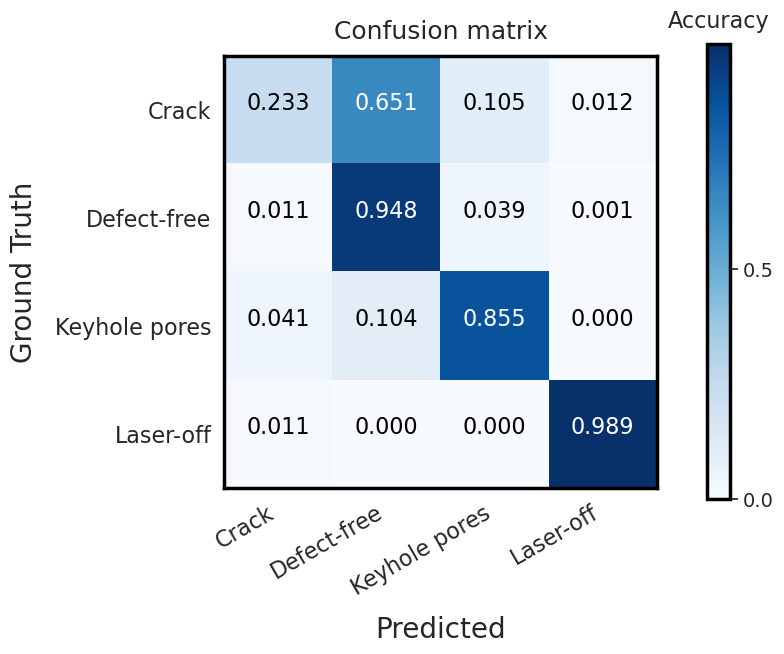

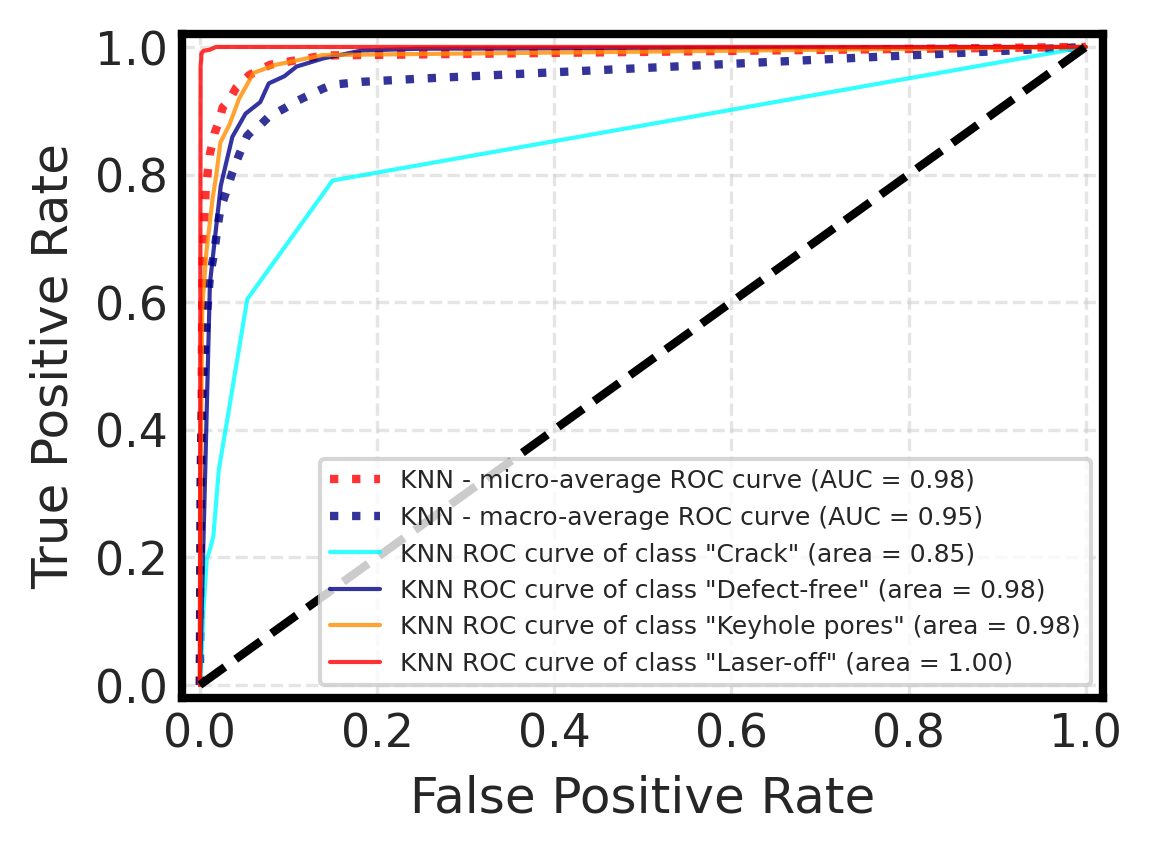

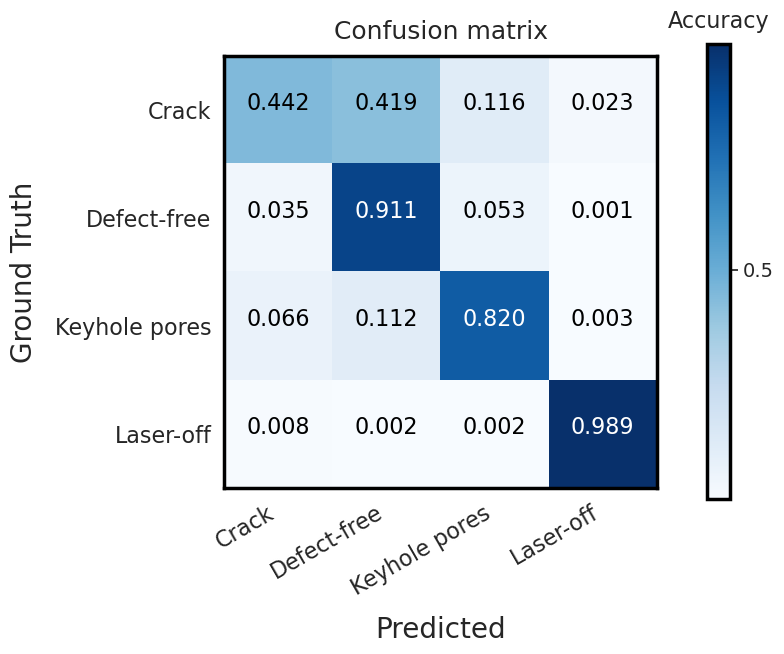

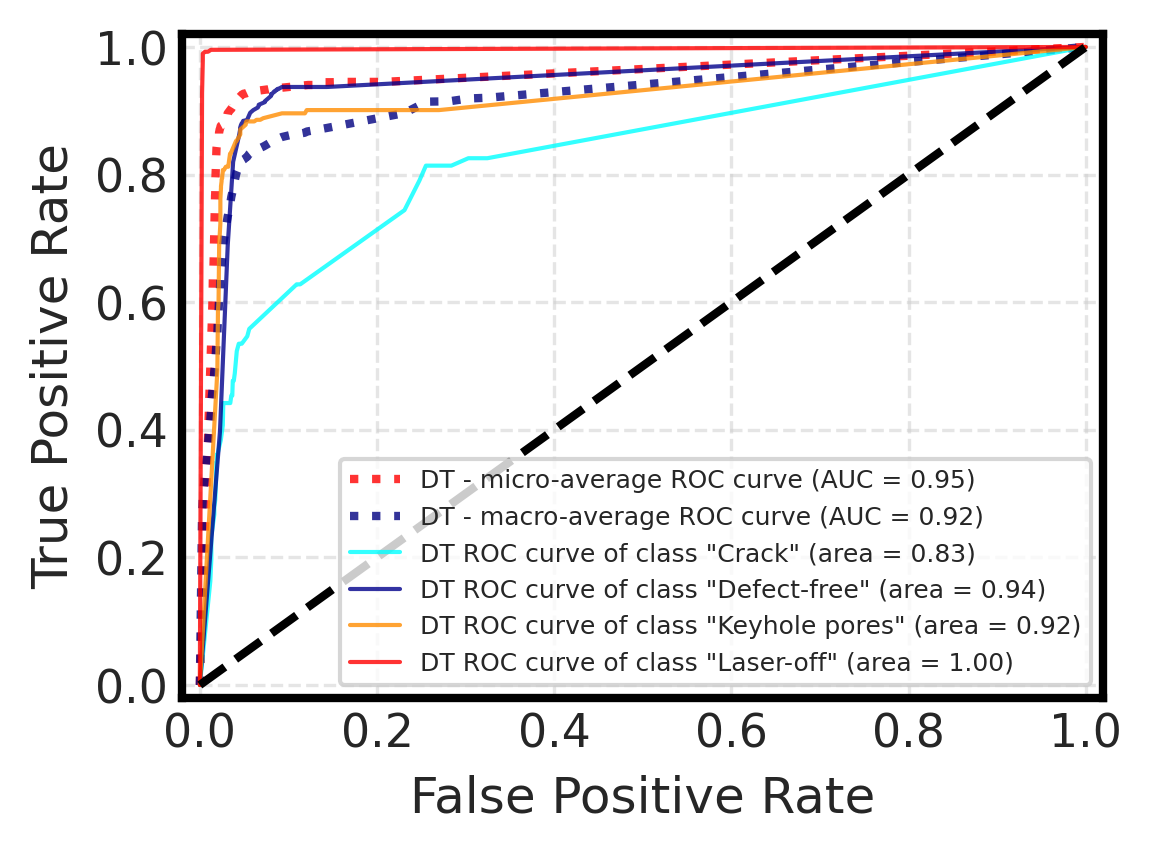

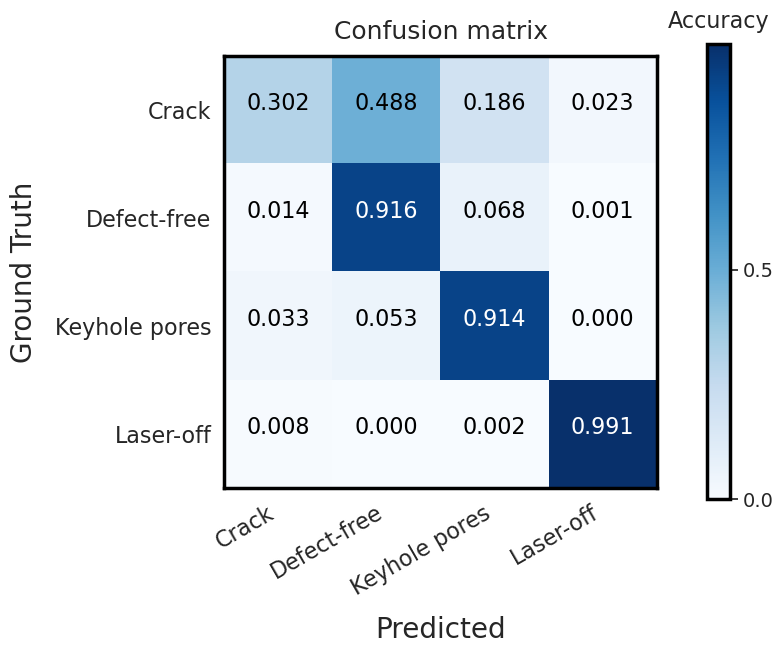

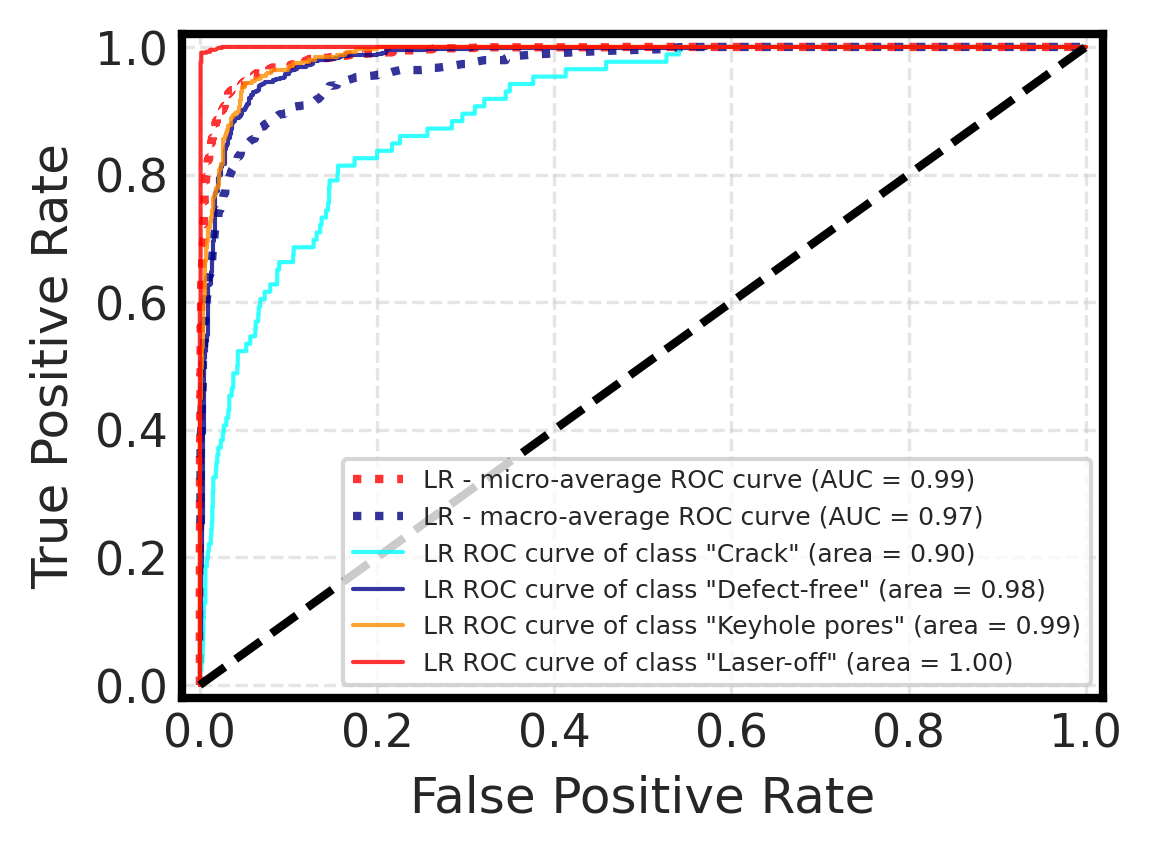

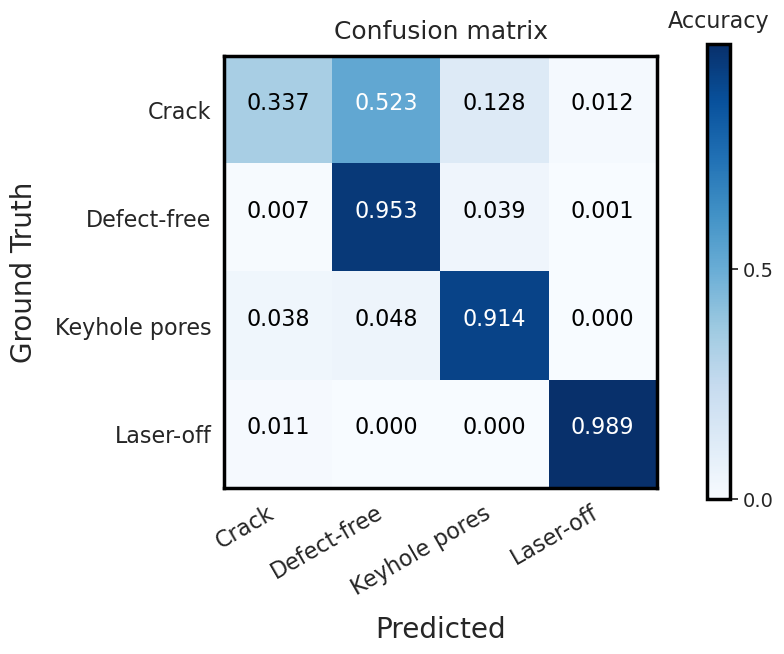

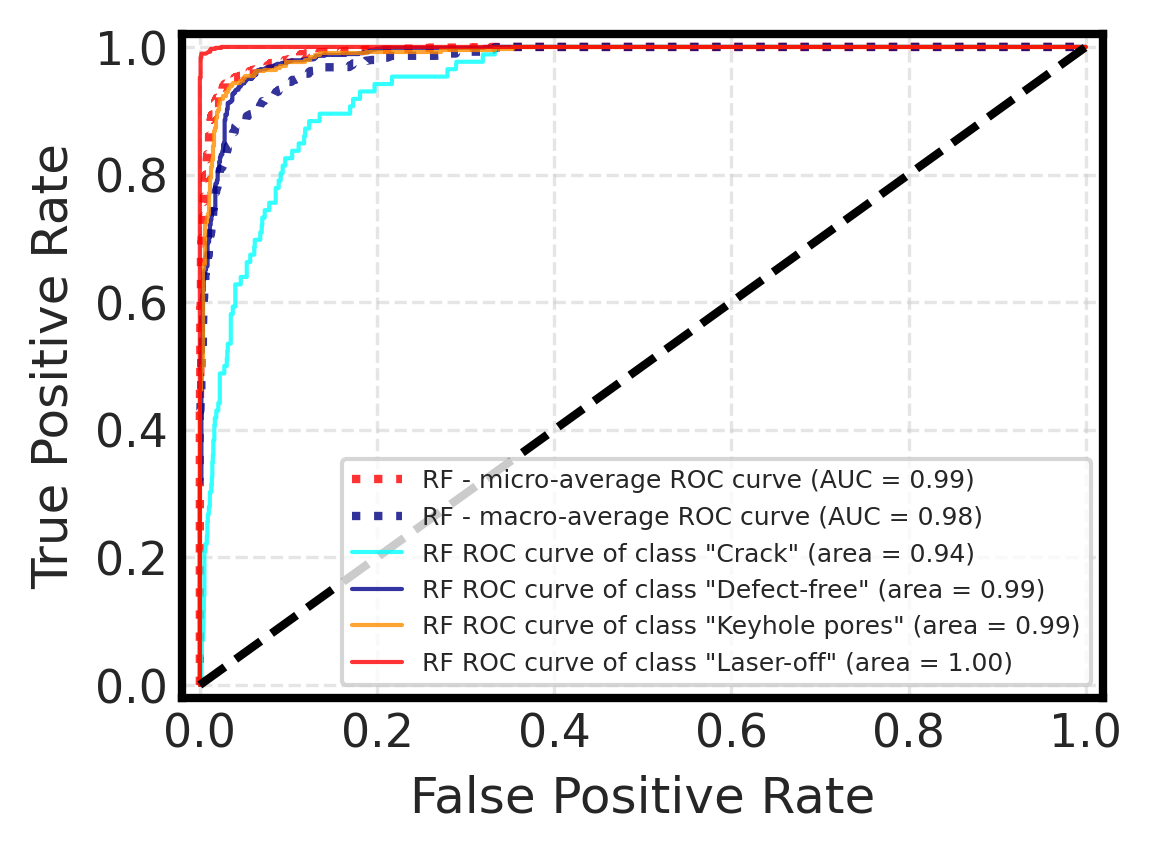

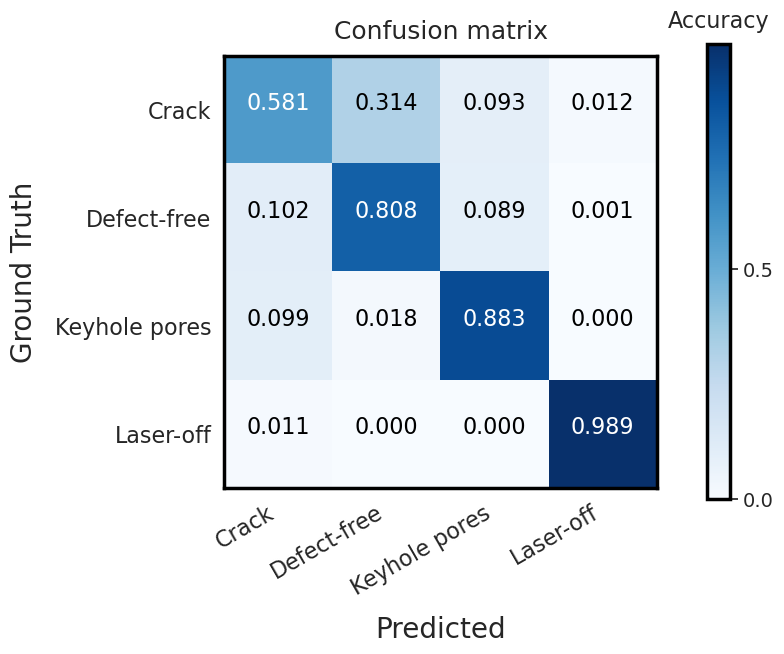

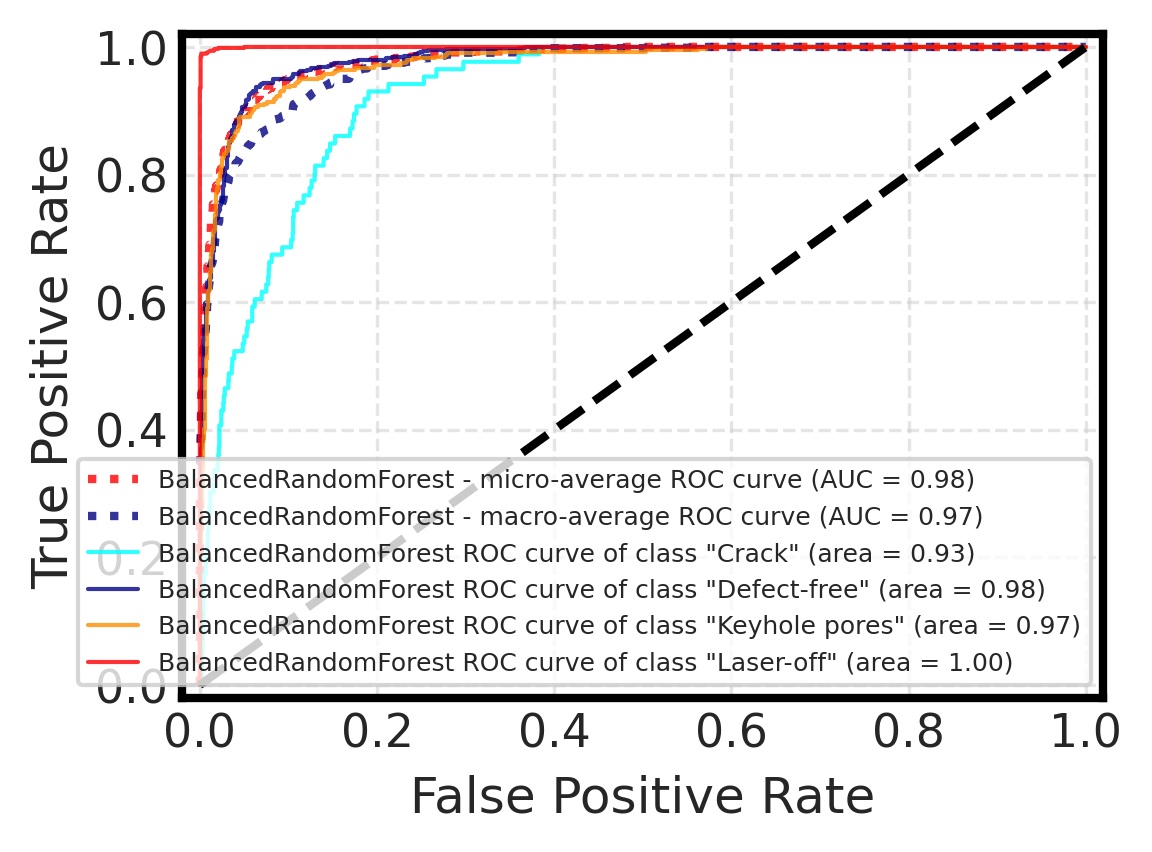

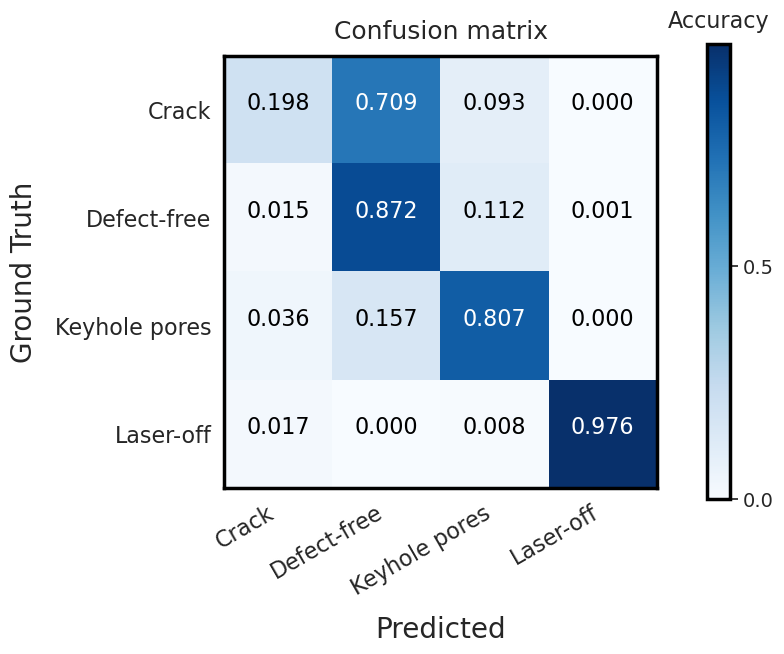

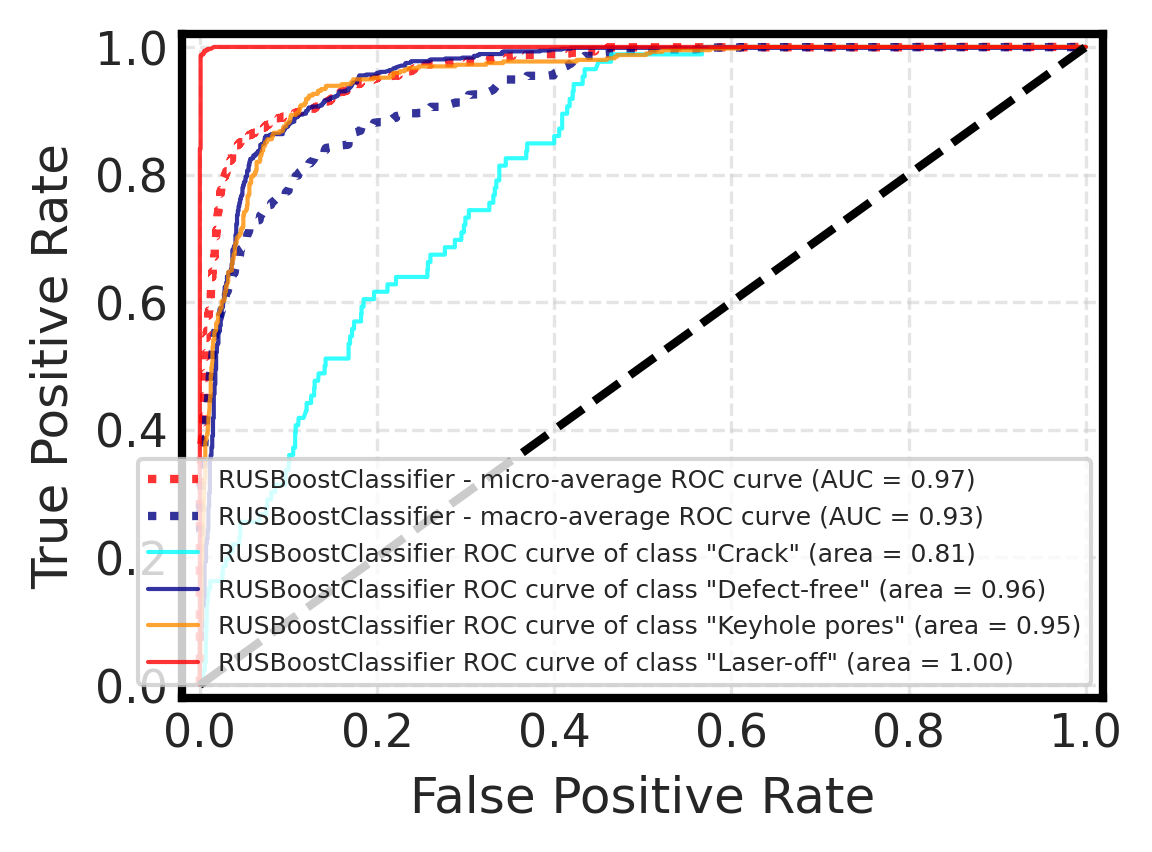

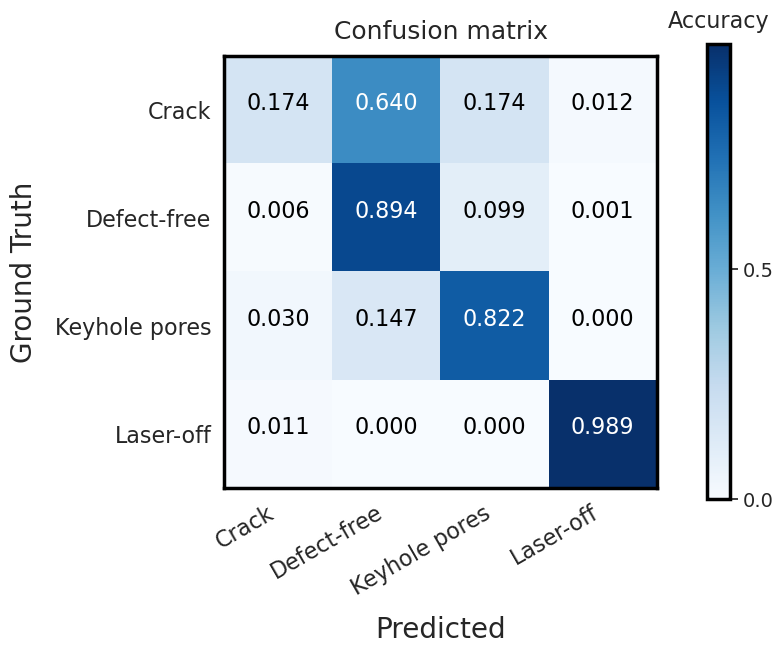

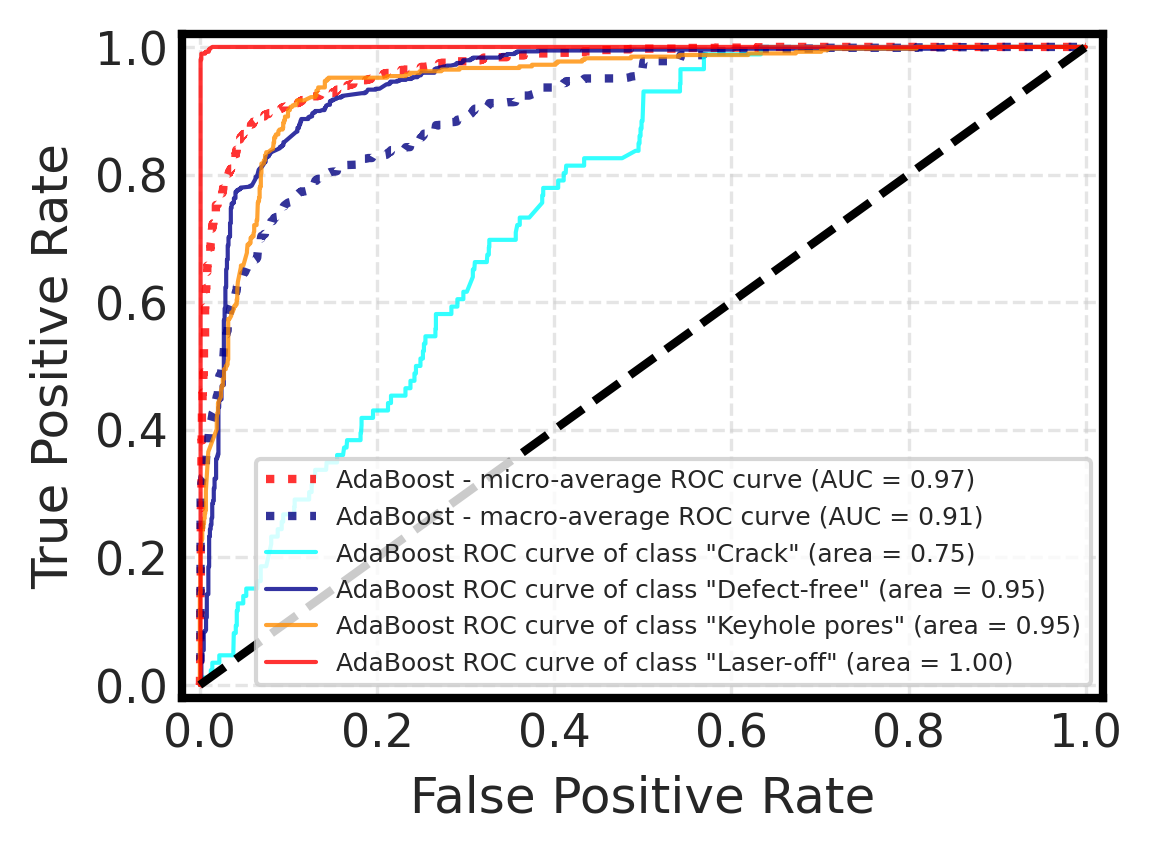

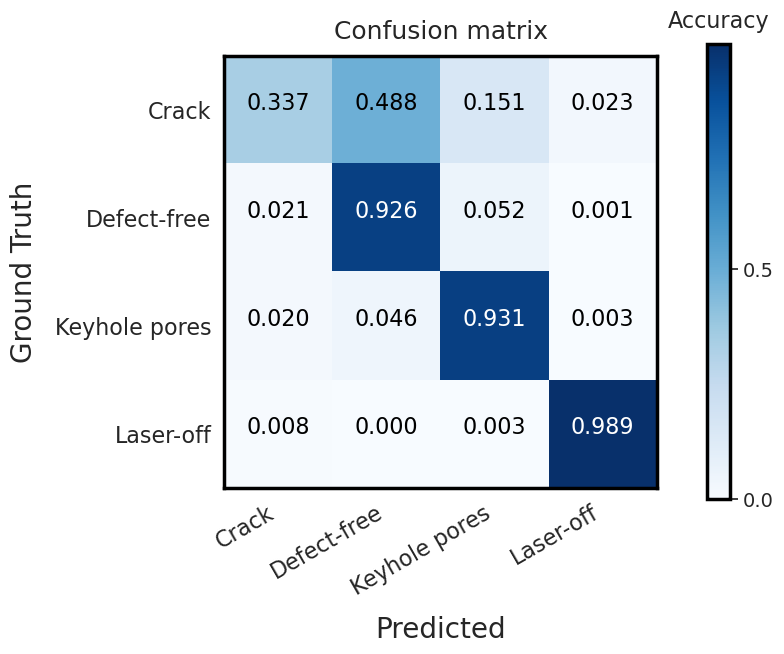

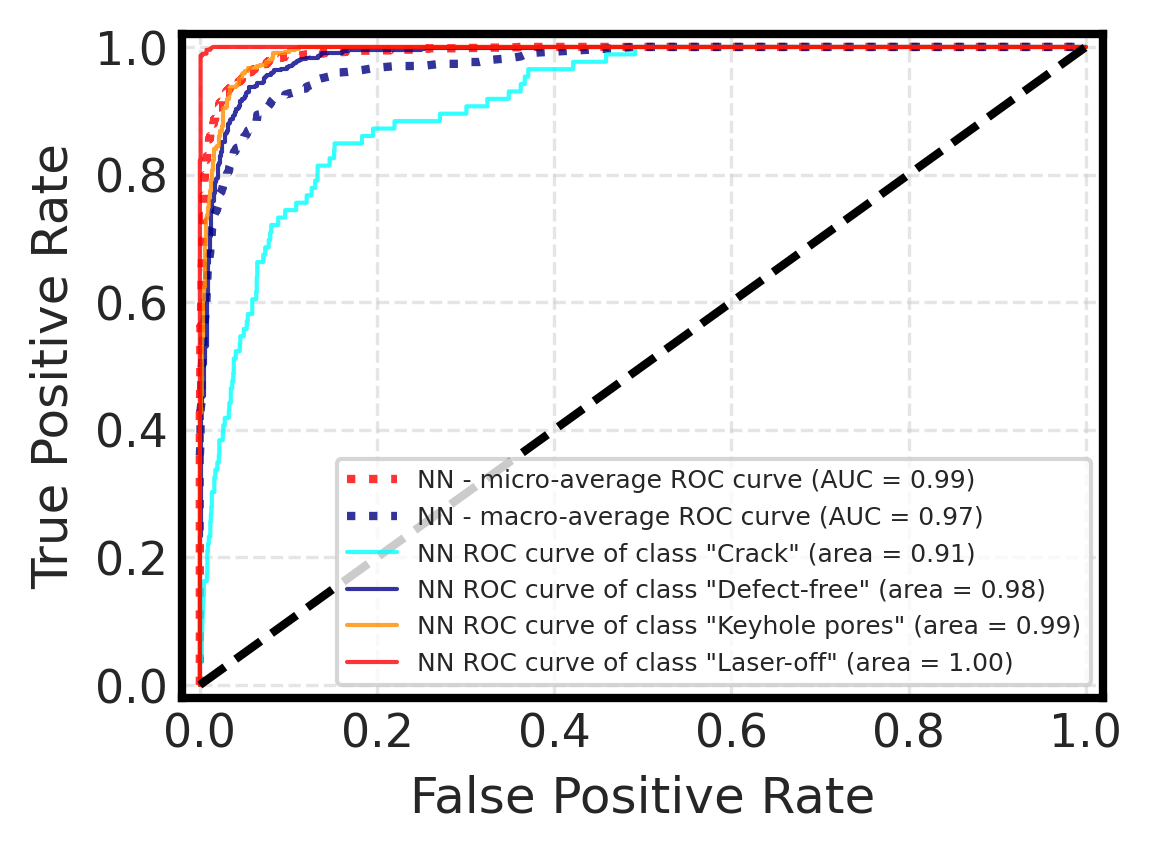

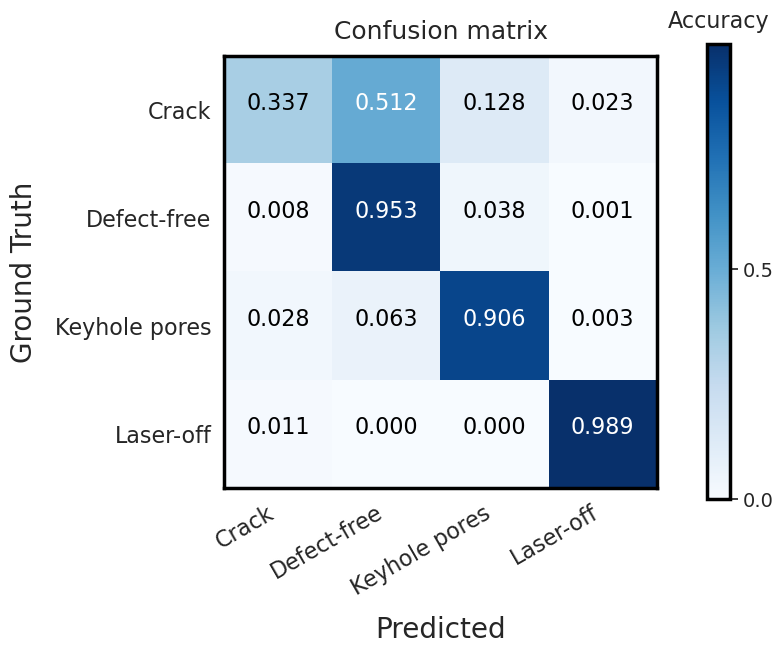

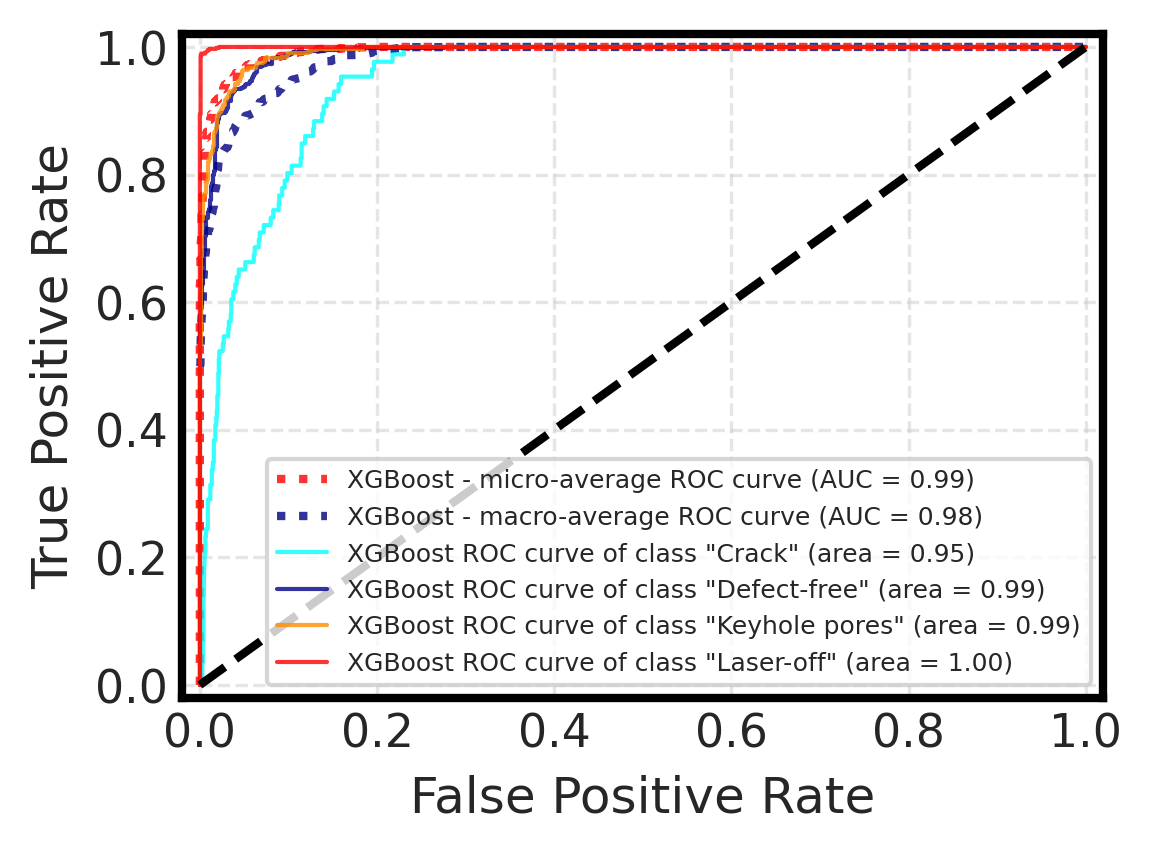

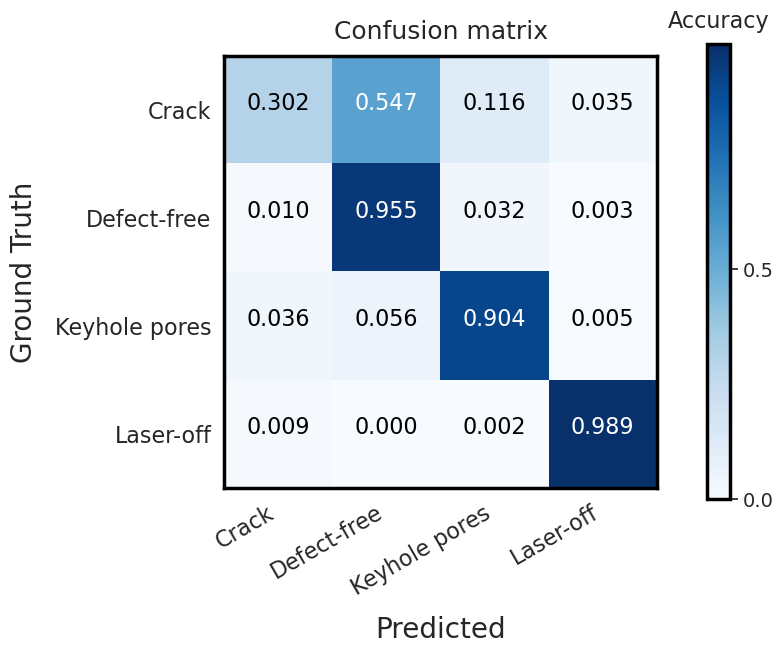

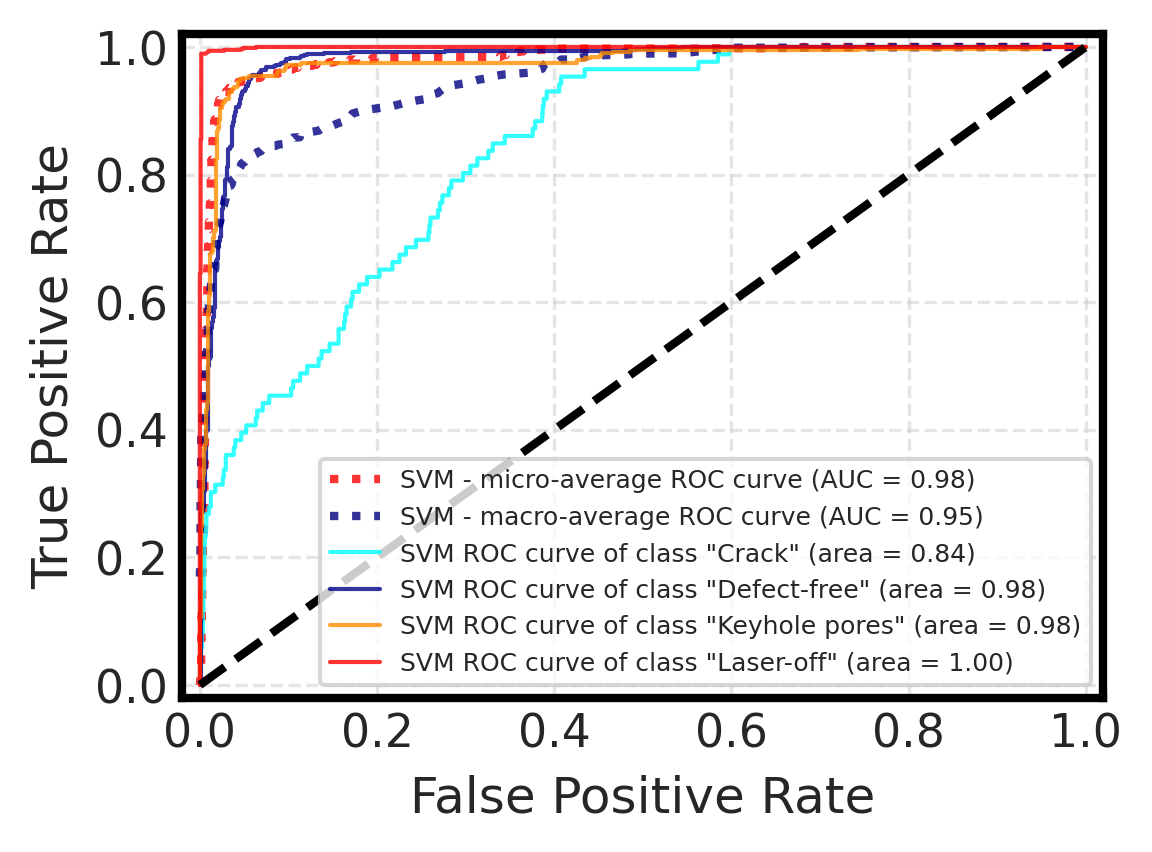

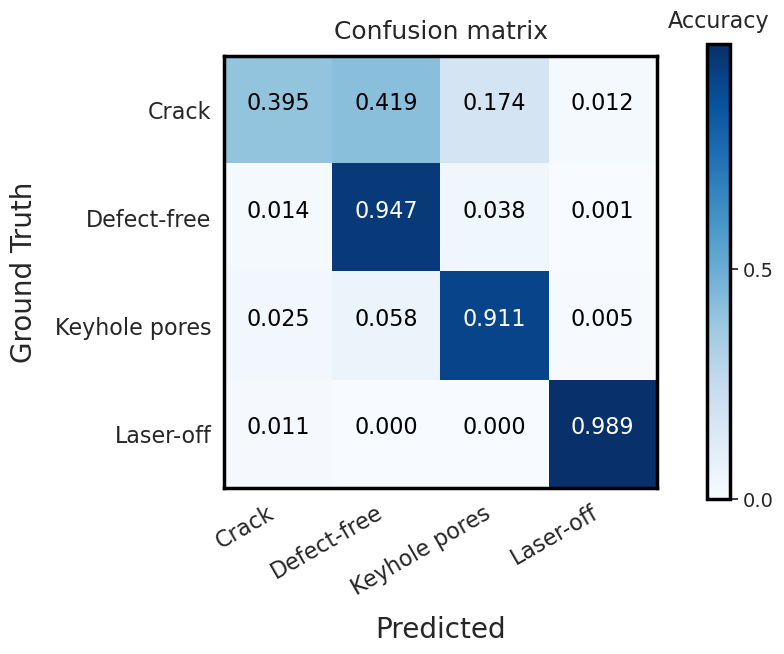

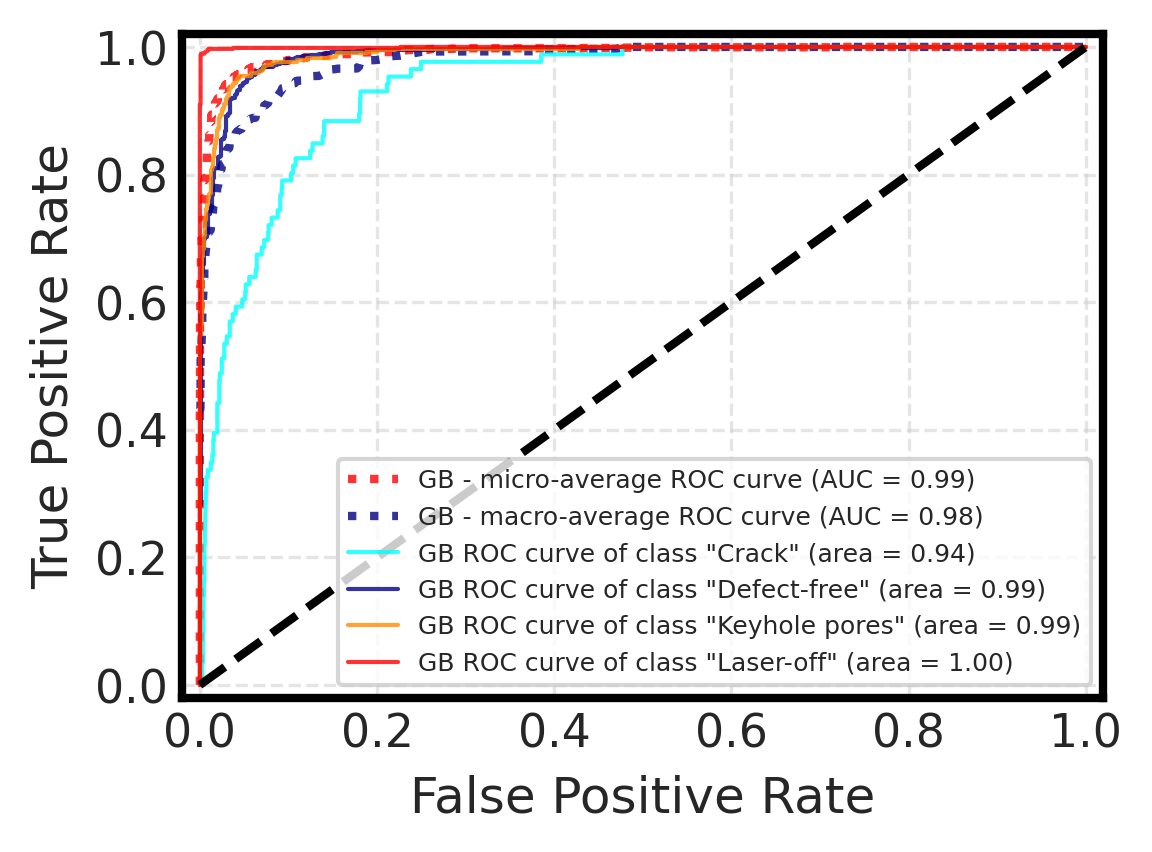

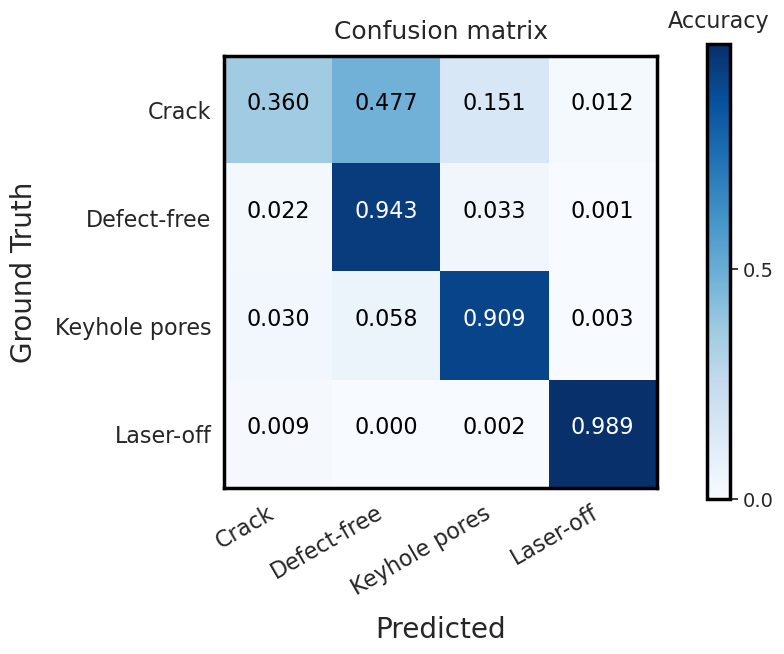

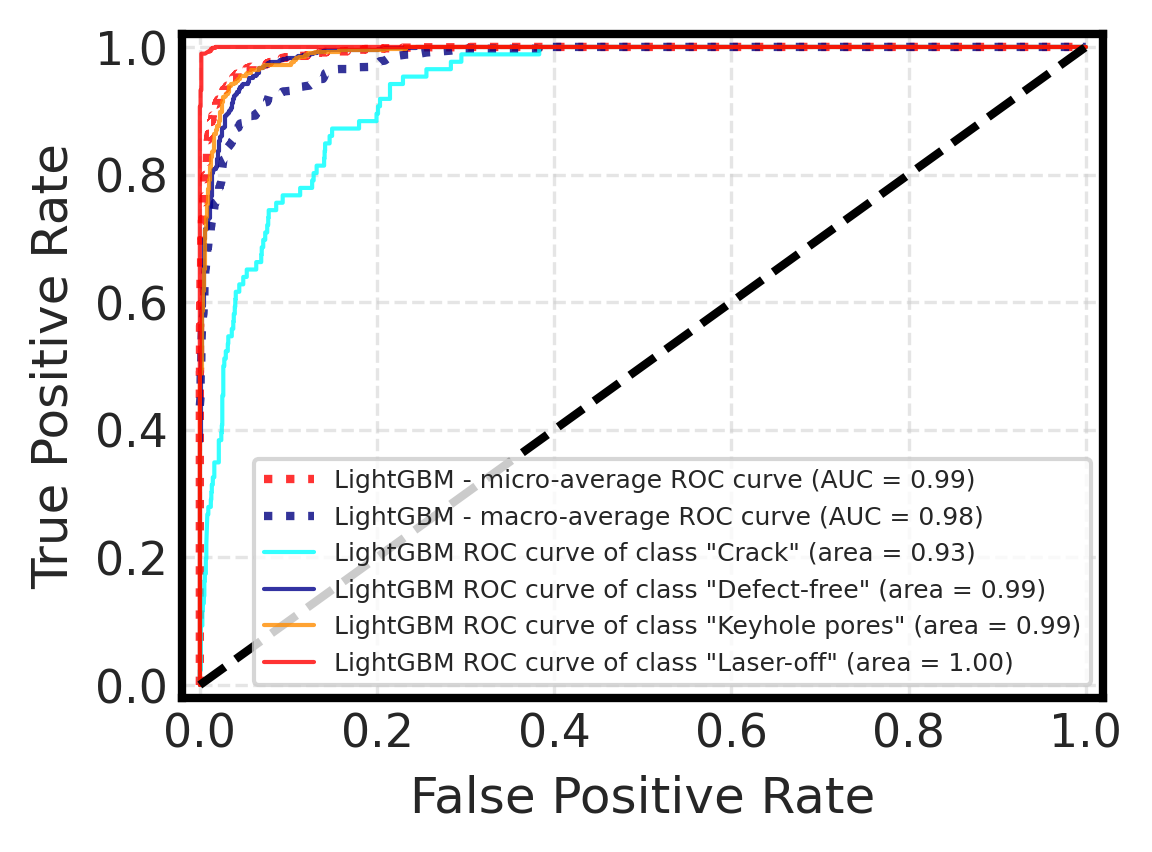

In [71]:
# Iterate over implemented models
for modeltoggle in ["KNN", "DT", "LR", "RF", "BalancedRandomForest", "RUSBoostClassifier", "AdaBoost", "NN", "XGBoost", "SVM", "GB", "LightGBM"]: 

    title = "Defect Prediction "
    labels_categorical_=(le.classes_).tolist() #['Cracks', 'Defect-free', 'Keyhole pores', 'Laser-off']
    n_classes = len(labels_categorical_)
    X = X_all_test_transformed
    Y = Y_all_test_encoded

    # One-hot-encode the ouput
    Y_test_ohe = label_binarize(Y_all_test, classes= labels_categorical_)

    if modeltoggle == 'KNN':
        model = knn_model
    elif modeltoggle == 'DT':
        model = dt_model
    elif modeltoggle == 'LR':
        model = lr_model
    elif modeltoggle == 'RF':
        model = rf_model
    elif modeltoggle == 'BalancedRandomForest':
        model = brf_model
    elif modeltoggle == 'RUSBoostClassifier':
        model = rus_model
    elif modeltoggle == 'AdaBoost':
        model = ada_model
    elif modeltoggle == 'GP':
        model = gp_model
    elif modeltoggle == 'NN':
        model = nn_model
    elif modeltoggle == 'XGBoost':
        model = xgb_model
    elif modeltoggle == 'SVM':
        model = svm_model
    elif modeltoggle == 'GB':
        model = gb_model
    elif modeltoggle == 'LightGBM':
        model = lgb_model

    ################--------------------------------- confusion matrix ------------------#####################
    ################---------------------------------------------------------------------#####################
    # for calculating the confusion matrix
    Y_predict = model.predict(X)
    # Category/ label that was wrongly classified by the model: View the class with WRONG classificaiton 
    pred_result = list(zip(Y, Y_predict))
    result_df = pd.DataFrame(pred_result, columns = ['label', 'pred_label'])
    result_df = result_df[result_df['label'] != result_df['pred_label']]
    print(classification_report(Y, Y_predict))
    
    conf_matrix(Y, Y_predict, classes=labels_categorical_)
    save_fig("confusion_"+ modeltoggle + "_" + "ALL")
    
    
    ################------------ Testing performance on k-fold on the model -------------#####################
    ################---------------------------------------------------------------------#####################
    kf = KFold(n_splits=5)
    skf = StratifiedKFold(n_splits=5)
    trains = []
    tests = []
    
    # for train, test in kf.split(X):
    for train, test in skf.split(X, Y):

        X_shuffle, y_shuffle = shuffle(X, Y, random_state=0)
        y_shuffle = np.array(y_shuffle)

        # X_cv_train_before = X_shuffle[train]
        # X_cv_test_before = X_shuffle[test]
        X_train_cv = X_shuffle[train]
        X_test_cv = X_shuffle[test]
        y_train_cv = y_shuffle[train]
        y_test_cv = y_shuffle[test]
        # clf.fit(X_train_cv, y_train_cv)
        # trains.append(clf.score(X_train_cv, y_train_cv))
        tests.append(model.score(X_test_cv, y_test_cv))
    

    ################--------------- AUC-ROC score measurement --------------------#####################

    # ----------------Learn to predict each class against the other------------------------
    # classifier = OneVsRestClassifier(model)
    if modeltoggle == 'SVM':
        # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        y_score = model.decision_function(X)
    else:
        # y_score = classifier.fit(X_train, Y_train_ohe).predict_proba(X_test)
        y_score = model.predict_proba(X)
    
    # ---------------Compute ROC curve and ROC area for each class-------------------------
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_ohe.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ----------------------------------Plot all ROC curves-------------------------------
    plt.figure(figsize = (4,3), dpi = 300)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    
         
    #---------------------------(1) micro and macro ROC curve---------------------------
    plt.plot(fpr["micro"], tpr["micro"],
             label=modeltoggle + ' - micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='red', linestyle=':', linewidth=2, alpha = 0.8) #deeppink, midnightblue

    plt.plot(fpr["macro"], tpr["macro"],
             label=modeltoggle + ' - macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2, alpha = 0.8) #navy, gold
    
    #---------------------------(2) ROC curve for each class---------------------------
    colors = cycle(["aqua", "darkblue", "darkorange", "red", 'green', 'silver', 'yellow', 'olive'])
    # colors = cycle(['0.45', 'steelblue',  'olive', 'silver'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],tpr[i],color=color,
                 lw=1, alpha = 0.8,
                 label=modeltoggle + " ROC curve of class \"{0}\" (area = {1:0.2f})".format(labels_categorical_[i], roc_auc[i])) 
        
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.title("ROC curve")
    plt.legend(loc="lower right",  fontsize = '6', frameon = True, framealpha=0.8)
    # plt.show()
    plt.grid(linestyle='--', alpha=0.5, linewidth=0.8)
    
    #---------------------------------Aggregate information----------------------------------
    tests = np.array(tests)

    test_accuracy_mean = tests.mean()
    test_accuracy_std = tests.std()
    
    auc_score_list = []
    auc_score_list.append(auc(fpr["micro"], tpr["micro"]))
    
    auc_score_array = np.array(auc_score_list)
    auc_mean = auc_score_array.mean()
    auc_std = auc_score_array.std()
    
    
    # store into list
    auc_mean_list.append(auc_mean)
    auc_std_list.append(auc_std)
    accuracy_mean_list.append(test_accuracy_mean)
    accuracy_std_list.append(test_accuracy_std)
    
    print('Test Accuracy (cross-validation) for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(test_accuracy_mean, test_accuracy_std))
    print('micro-averaging AUC for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(auc_mean, auc_std))
    save_fig("ROC_" + modeltoggle + "_" + "audio_visual")

## Save trained model into folder

In [79]:
from joblib import dump, load
import joblib

KNN_file = os.path.join(model_path, 'KNN.joblib')
DT_file = os.path.join(model_path, 'DT.joblib')
AdaBoost_file = os.path.join(model_path, 'AdaBoost.joblib')
RF_file = os.path.join(model_path, 'RF.joblib')
BalancedRandomForest_file = os.path.join(model_path, 'BalancedRandomForest.joblib')
LightGBM_file = os.path.join(model_path, 'LightGBM.joblib')
XGBoost_file = os.path.join(model_path, 'XGBoost.joblib')
LR_file = os.path.join(model_path, 'LR.joblib')
SVM_file = os.path.join(model_path, 'SVM.joblib')
GB_file = os.path.join(model_path, 'GB.joblib')
RUSBoostClassifier_file = os.path.join(model_path, 'RUSBoostClassifier.joblib')
NN_file = os.path.join(model_path, 'NN.joblib')

# Define the paths
paths = {
    'KNN': KNN_file,
    'DT': DT_file,
    'AdaBoost': AdaBoost_file,
    'RF': RF_file,
    'BalancedRandomForest': BalancedRandomForest_file,
    'LightGBM': LightGBM_file,
    'XGBoost': XGBoost_file,
    'LR': LR_file,
    'SVM': SVM_file,
    'GB': GB_file,
    'RUSBoostClassifier': RUSBoostClassifier_file,
    # 'GP': GP_file, 
    'NN': NN_file
}

# Define the models
models = {
    'KNN': knn_model,
    'DT': dt_model,
    'AdaBoost': ada_model,
    'RF': rf_model,
    'BalancedRandomForest': brf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'LR': lr_model,
    'SVM': svm_model,  
    'GB': gb_model,  
    'RUSBoostClassifier': rus_model,
    # 'GP': gp_model,  
    'NN': nn_model  
}

# Save models
for name, model in models.items():
    dump(model, paths[name])

In [80]:
# load the model from disk
loaded_model = joblib.load(open(SVM_file, 'rb'))
result = loaded_model.score(X_all_test_transformed, Y_all_test_encoded)
print(result)

0.9263836646963998


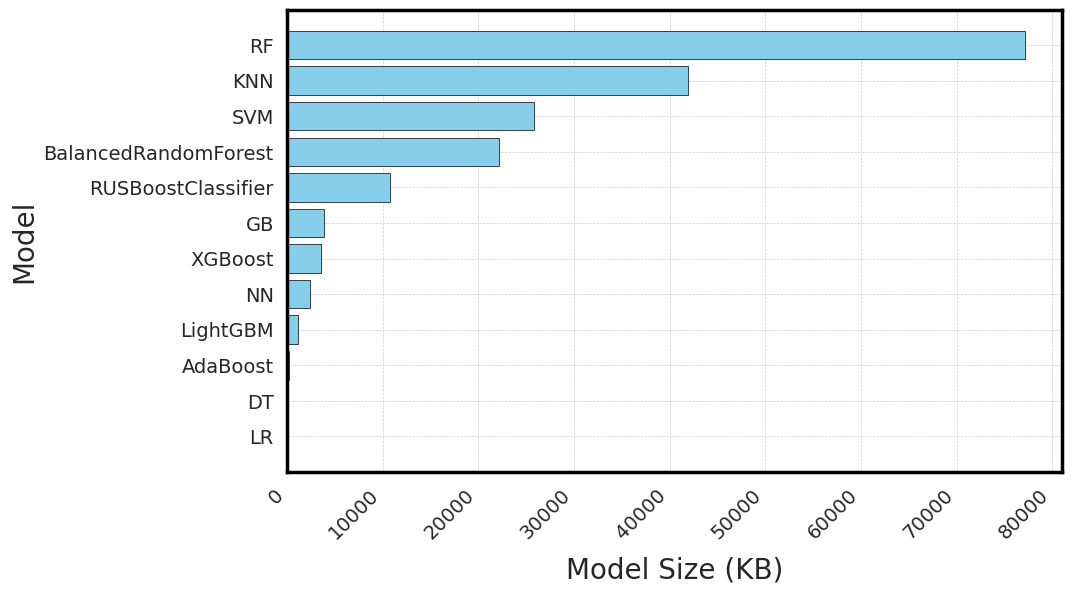

In [101]:
def plot_model_sizes(paths, fontsize=14):
    model_sizes = {}
    for name, path in paths.items():
        model_sizes[name] = os.path.getsize(path) // 1024  # Size in KB

    sorted_model_sizes = {k: v for k, v in sorted(model_sizes.items(), key=lambda item: item[1])}

    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_model_sizes.keys()), list(sorted_model_sizes.values()), 
             color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Model Size (KB)', fontsize=fontsize+6, labelpad=10)
    plt.ylabel('Model', fontsize=fontsize+6)
    plt.xticks(fontsize=fontsize, rotation=45, ha='right')
    plt.yticks(fontsize=fontsize)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Example usage:
plot_model_sizes(paths)

## Model performance statistics

BalancedRandomForest_fileTo evaluate the effectiveness of the classification model, metrics used to assess are:

1. **$Precision = TP/(FP+TP)$**

**Precision** provides the *positive predictive value, the proportion of samples that belong in category $x$ that are correctly placed in category $x$*. Example, among all predicted defect, how many did I predict correctly? High precision is with low FP (predict to be cracks but actually is not).

2. **$f1 = 2*(Precision*Recall)/(Precision + Recall)$**

**Weighted average for precision and recall**. This score takes both FN and FP into account as $Recall = TP/(FN+TP)$. This is better metric for evaluating an uneven class distribution problem, which is the case in this project. 

3. $Accuracy = (TP+TN)/(All predict)$

Model achieve pretty high **>80%** overall accuracy.

The model able to classify well for defects sounds. However, it did badly on the detecting ***cracks***

- In conclusion, the initial model without Hyper-parameter tuning did pretty well in general. But it does not outperform the traditional ML algorithms. And it did poorly in classifying the cracking regimes.

### Category/ label that was wrongly classified by the model

In [83]:
models_list = ["KNN", "DT", "LR", "RF", "BalancedRandomForest", "RUSBoostClassifier", "AdaBoost", "NN", "XGBoost", "SVM", "GB", "LightGBM"]

In [82]:
accuracy_mean_list

[0.9102539709994522,
 0.8978955864971605,
 0.914021735997002,
 0.9290625270258583,
 0.8780189685491078,
 0.8640404739254519,
 0.8796246648793564,
 0.9226210037764131,
 0.9274496238000518,
 0.9263786791201822,
 0.9290654097840815,
 0.9253019689238663]

Saving figure Accuracy-all(audio_visual)
Saving figure AUC-all(audio_visual)


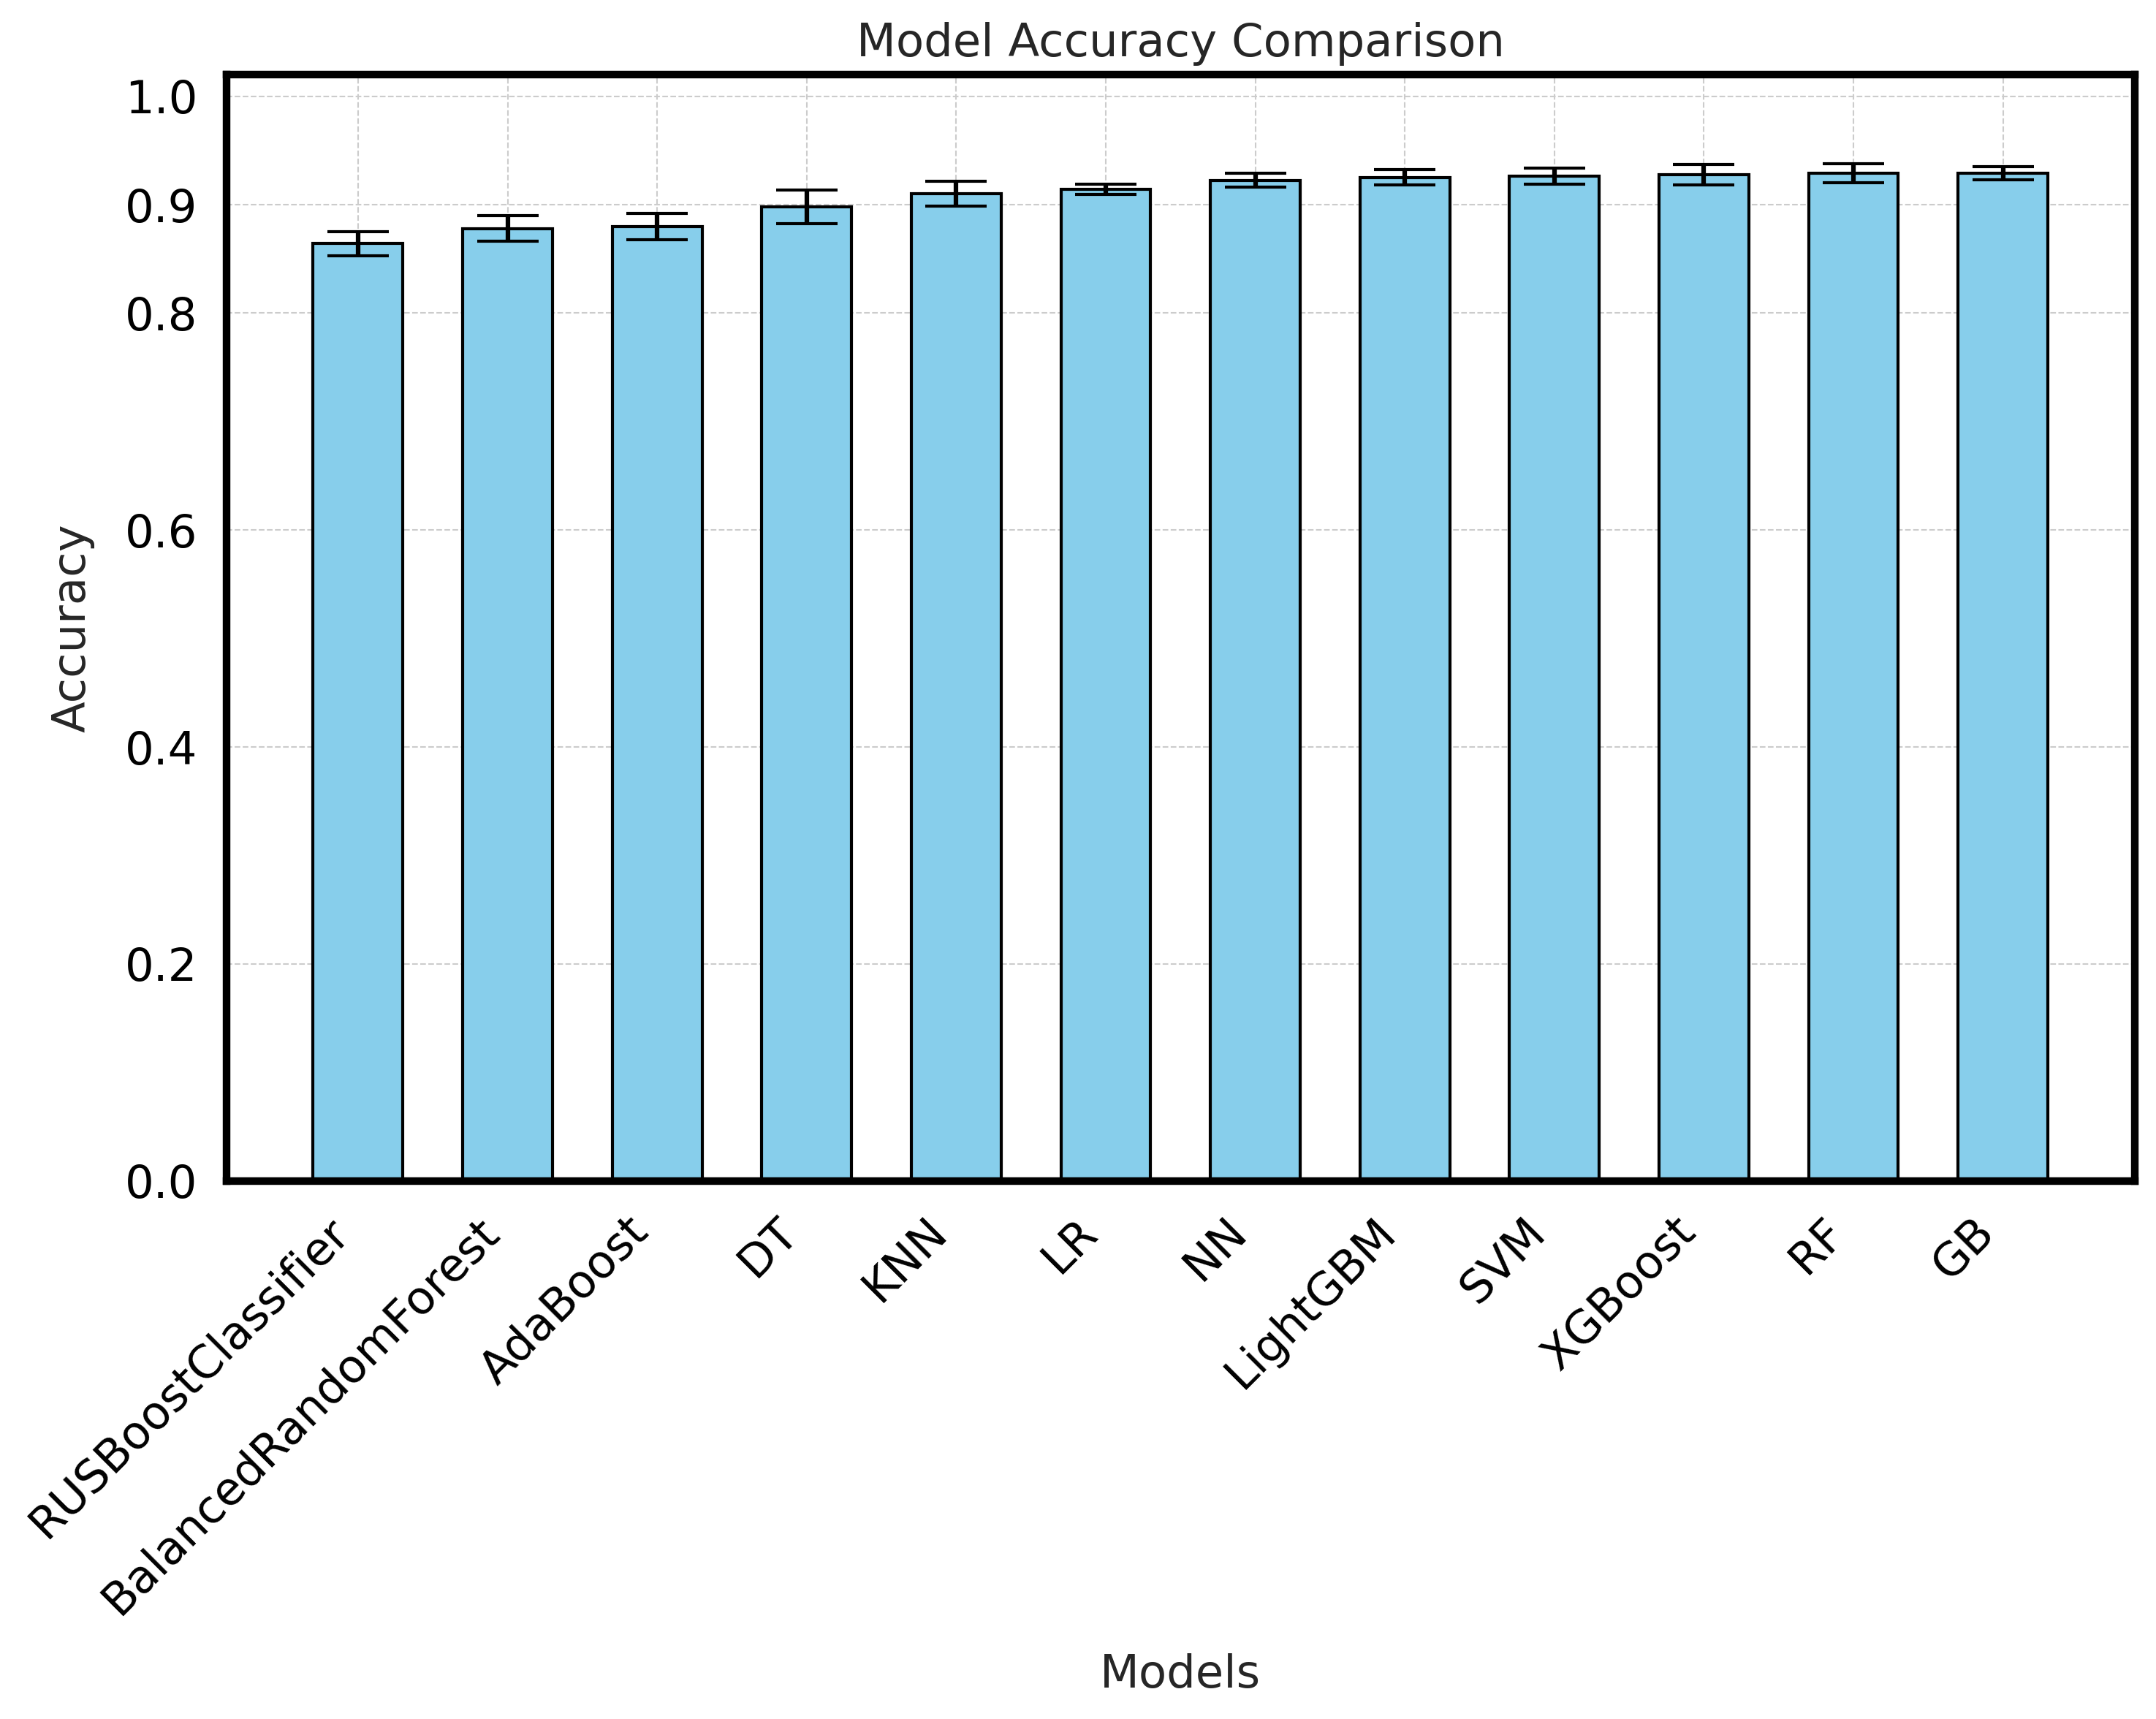

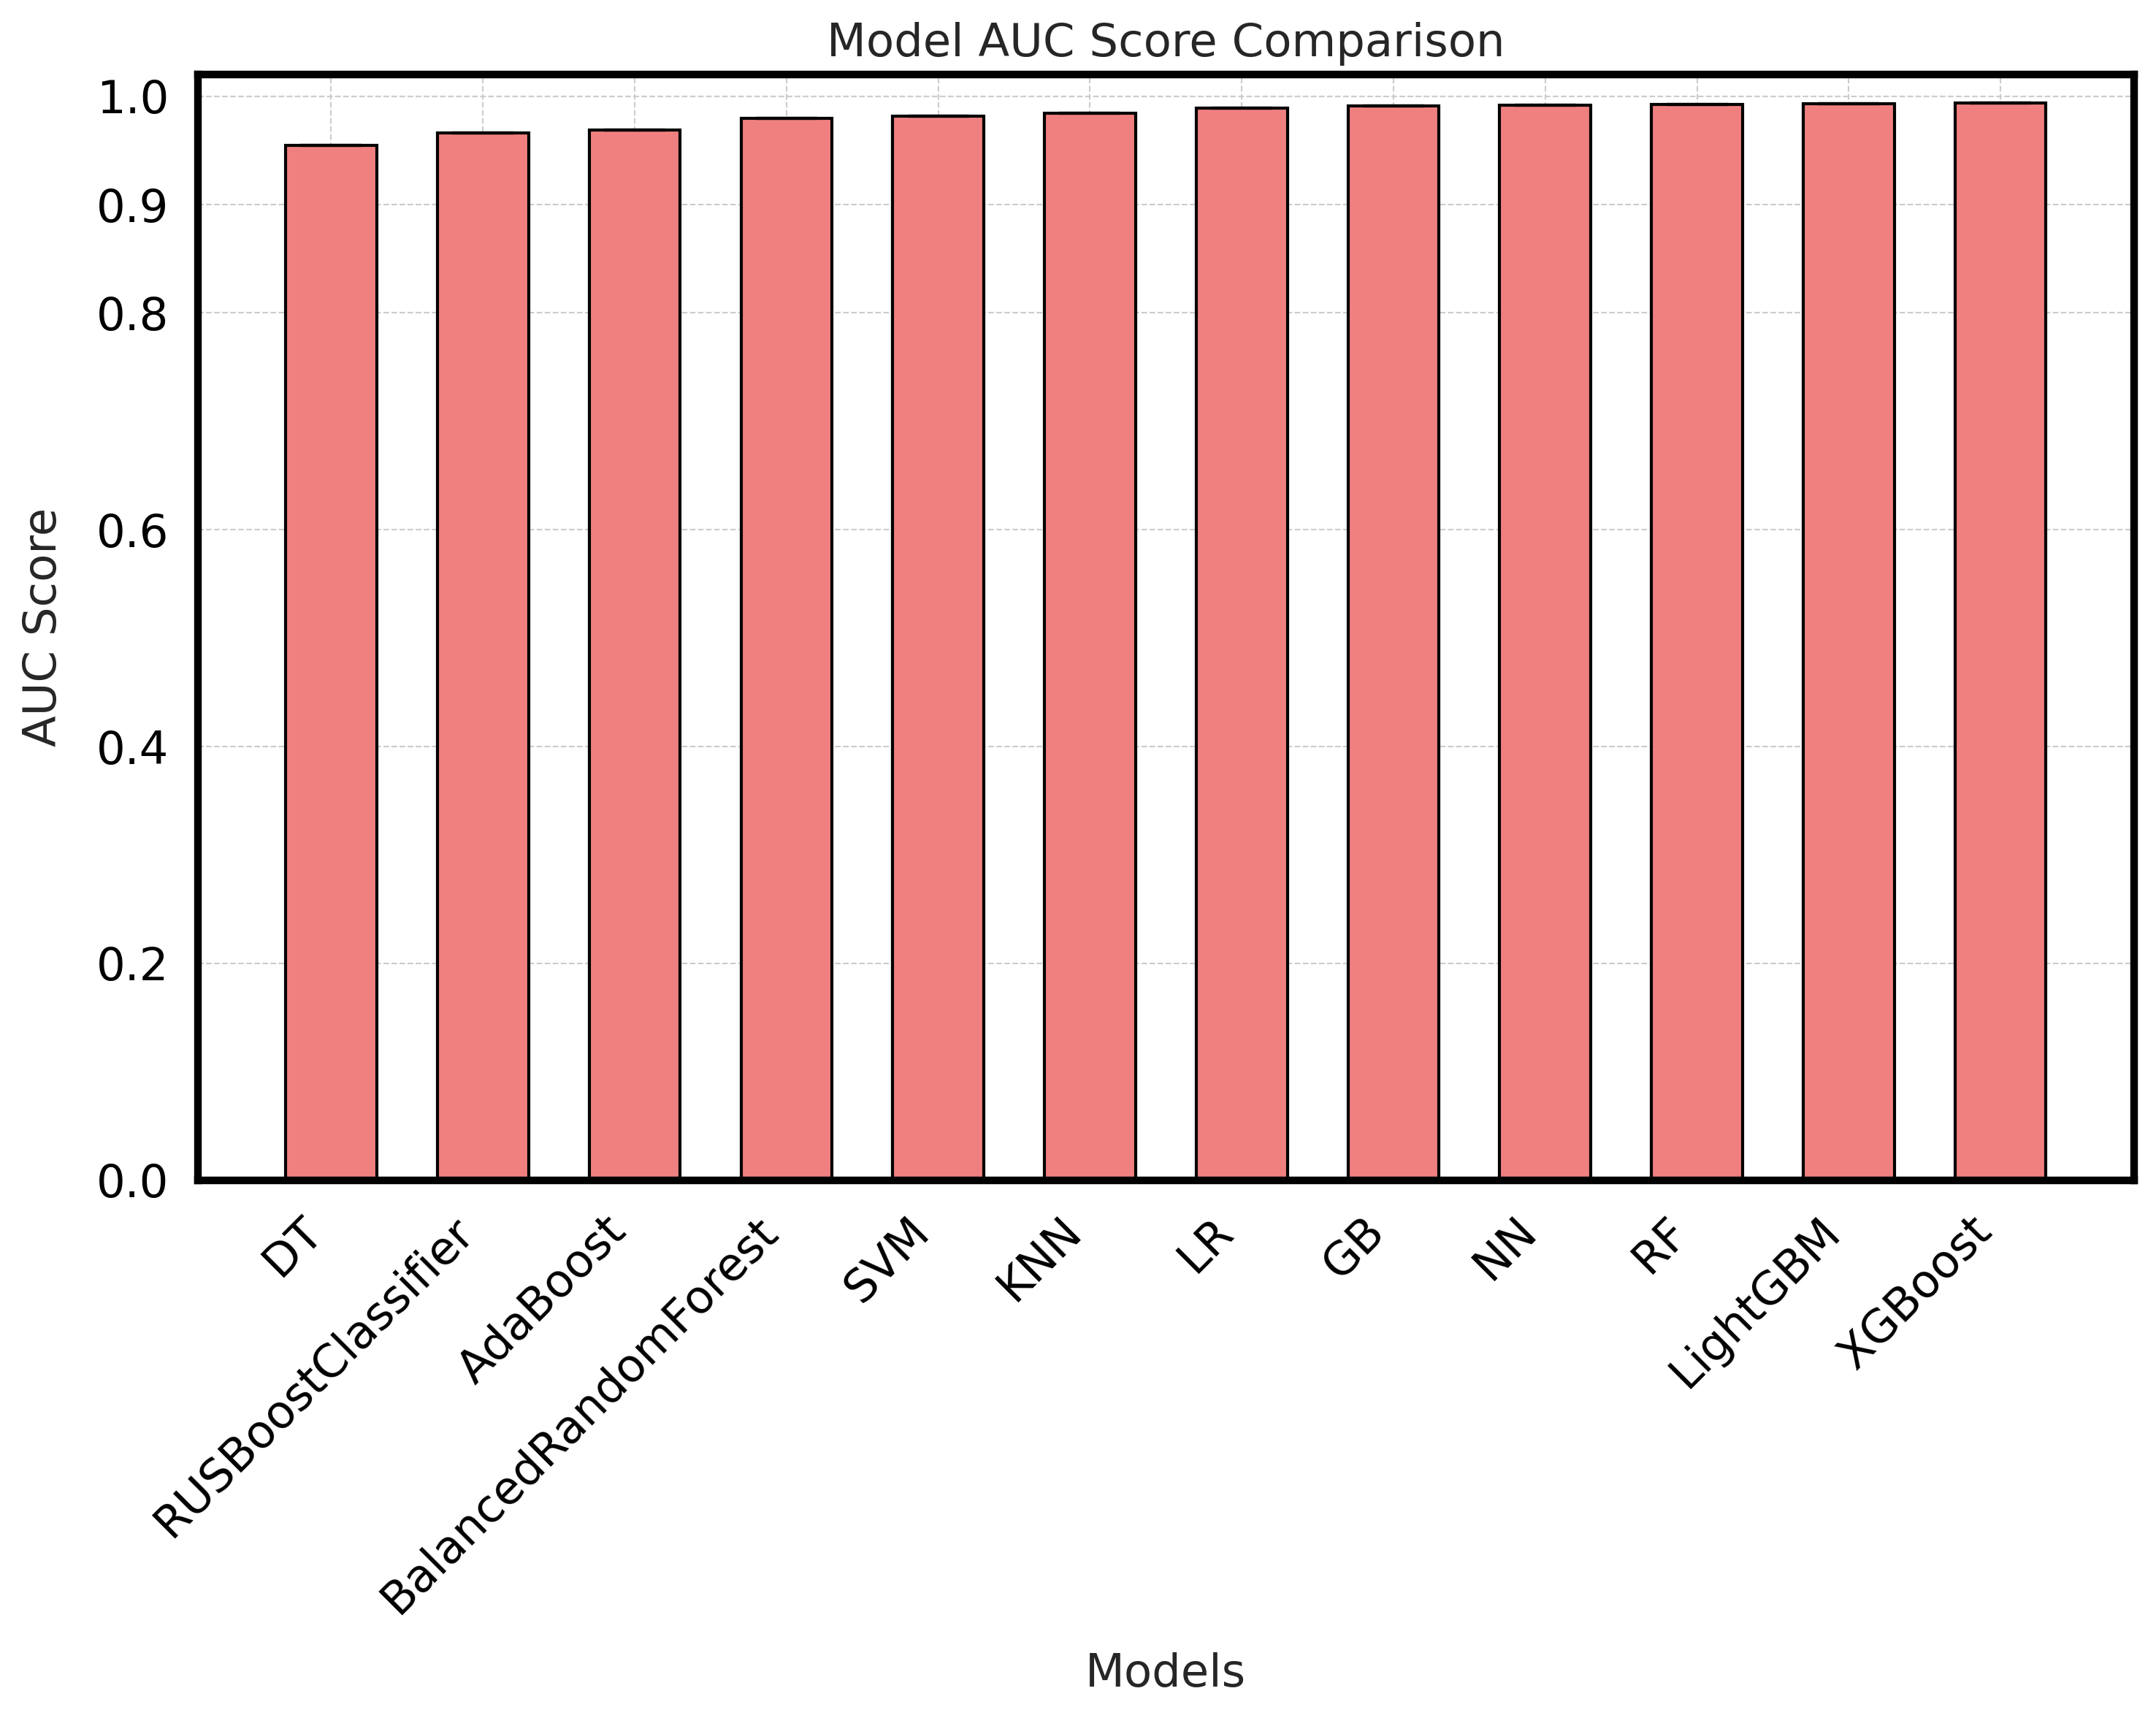

In [84]:
def plot_model_metrics(models, mean_list, std_list, metric_name, color, 
                       bar_width=0.6, edge_width=1, fontsize=15, 
                       labelpad=10, figsize=(10, 8), dpi=300, add_baseline=False):
    
    # If baseline model is to be added (only for accuracy)
    if add_baseline:
        models.append("baseline model")
        mean_list.append(0.26)
        std_list.append(0)
    
    # Sorting by mean values
    sorted_indices = np.argsort(mean_list)
    sorted_models = np.array(models)[sorted_indices]
    sorted_means = np.array(mean_list)[sorted_indices]
    sorted_stds = np.array(std_list)[sorted_indices]
    
    # Plotting
    plt.figure(figsize=figsize, dpi=dpi)
    plt.bar(sorted_models, sorted_means, yerr=sorted_stds, 
            capsize=10, color=color, width=bar_width, 
            edgecolor='black', linewidth=edge_width)
    
    plt.ylabel(metric_name, fontsize=fontsize, labelpad=labelpad)
    plt.title(f'Model {metric_name} Comparison', fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize, rotation=45,  ha='right')
    plt.yticks(fontsize=fontsize)
    plt.xlabel("Models", fontsize=fontsize, labelpad=labelpad)
    
    # Add dotted grid
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    
    # Show ticks outwards
    plt.tick_params(direction='out', length=6, width=2, colors='black')
    
    plt.tight_layout()
    plt.ylim([0, 1.02])
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
    # plt.show()

# Plotting Accuracy with improvements
plot_model_metrics(models_list.copy(), accuracy_mean_list.copy(), accuracy_std_list.copy(), 
                   "Accuracy", 'skyblue', add_baseline=False)
save_fig ("Accuracy-all(audio_visual)")
# Plotting AUC with improvements
plot_model_metrics(models_list.copy(), auc_mean_list.copy(), auc_std_list.copy(), 
                   "AUC Score", 'lightcoral')
save_fig ("AUC-all(audio_visual)")

## Analyze the inference time

1. Warm-Up Runs: A few 'warm-up' runs are often performed before the timing measurements to ensure that any lazy loading, caching, or other one-time operations have been completed.

2. High-Resolution Timers: High-resolution timers (such as Python's time.perf_counter() or C++'s std::chrono) are used to measure the time elapsed.

3. Excluding Data Loading: The time taken for just the model to make a prediction is measured, excluding any data loading or pre-processing time unless that is also a part of what is being evaluated.

4. GPU/CPU Synchronization: If using a GPU, it's important to make sure to synchronize the CPU and GPU computations to accurately measure the time taken.



In [86]:
import time

X_sample = X_all_test_transformed[10].reshape(1, -1)

# Dictionary to store inference times
inference_times = {}

# Number of runs
n_runs = 50

# Loop through all models and measure inference time
for model_name, model in models.items():
    times = []
    for _ in range(n_runs):
        start_time = time.perf_counter()
        predictions = model.predict(X_sample)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
        
    # Calculate average and standard deviation
    avg_time = sum(times) / n_runs
    std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
    
    inference_times[model_name] = (avg_time, std_time)
    print(f"Inference time for {model_name}: {avg_time:.6f} ± {std_time:.6f} seconds")

# Optional: Sort by average inference time
sorted_times = {k: v for k, v in sorted(inference_times.items(), key=lambda item: item[1][0])}
print("\nModels sorted by inference time:", sorted_times)

/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5


Inference time for KNN: 0.002305 ± 0.000880 seconds
Inference time for DT: 0.000108 ± 0.000077 seconds


/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5


Inference time for AdaBoost: 0.029299 ± 0.002697 seconds
Inference time for RF: 0.000284 ± 0.000185 seconds


/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray

Inference time for BalancedRandomForest: 0.022019 ± 0.002610 seconds
Inference time for LightGBM: 0.001023 ± 0.001967 seconds
Inference time for XGBoost: 0.004672 ± 0.005872 seconds
Inference time for LR: 0.000219 ± 0.000104 seconds
Inference time for SVM: 0.001116 ± 0.000090 seconds
Inference time for GB: 0.000359 ± 0.000116 seconds


/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5


Inference time for RUSBoostClassifier: 0.067395 ± 0.004974 seconds
Inference time for NN: 0.000369 ± 0.000241 seconds

Models sorted by inference time: {'DT': (0.00010758230040664784, 7.712614397393239e-05), 'LR': (0.00021890248011914083, 0.00010359253157234397), 'RF': (0.00028375442052492873, 0.0001848916688869934), 'GB': (0.0003593541806912981, 0.00011642057959875742), 'NN': (0.00036880517916870303, 0.00024101259632445762), 'LightGBM': (0.001023173839203082, 0.0019669983100063376), 'SVM': (0.0011157099400588776, 9.048124258850805e-05), 'KNN': (0.002304708179581212, 0.0008804267486148239), 'XGBoost': (0.004672267319983802, 0.00587248889929754), 'BalancedRandomForest': (0.02201861538007506, 0.0026095966329263568), 'AdaBoost': (0.02929862600052729, 0.002697378000662505), 'RUSBoostClassifier': (0.06739539499918465, 0.004974469904951753)}


/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5
/tmp/ipykernel_124050/1528511586.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  std_time = (sum((x - avg_time) ** 2 for x in times) / n_runs) ** 0.5


Saving figure inference_time


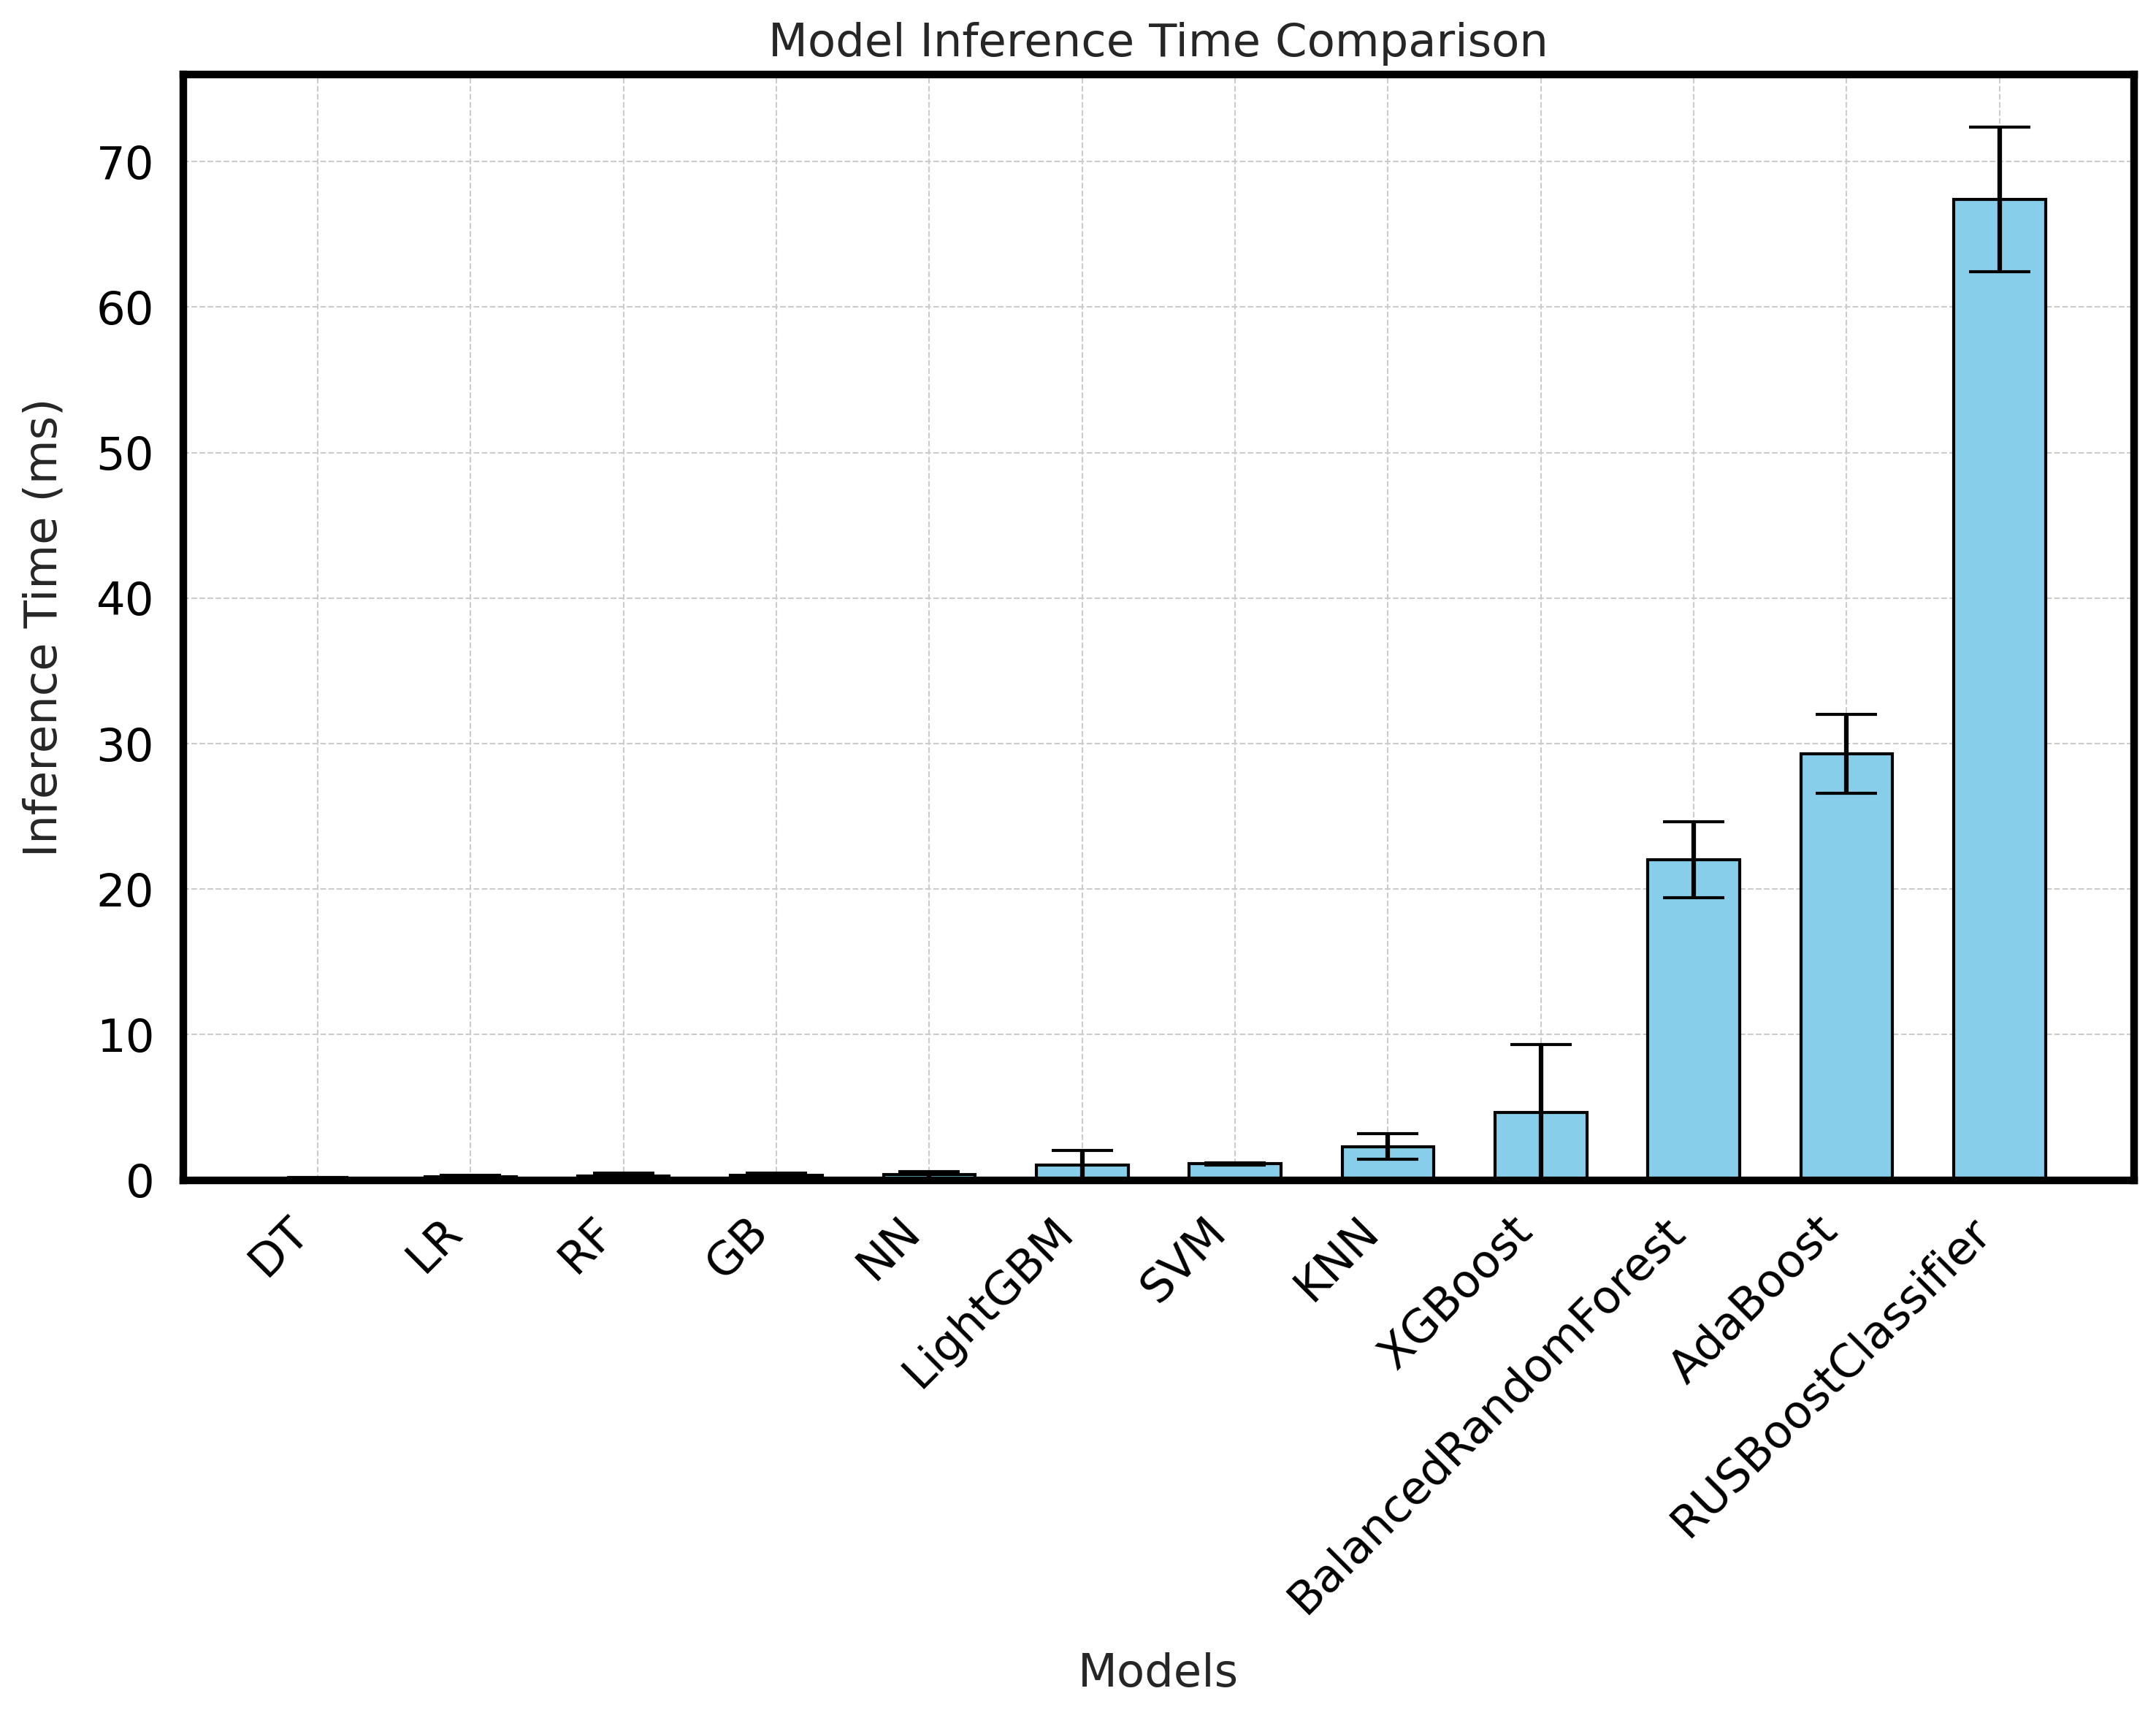

In [87]:
def plot_inference_time(models, inference_times, figsize=(10, 8), dpi=300):
    # Unpack times and standard deviations
    model_names = list(inference_times.keys())
    avg_times = [x[0] * 1e3 for x in inference_times.values()]  # Convert to milliseconds
    std_times = [x[1] * 1e3 for x in inference_times.values()]  # Convert to milliseconds
    
    # Sorting by mean values
    sorted_indices = np.argsort(avg_times)
    sorted_models = np.array(model_names)[sorted_indices]
    sorted_means = np.array(avg_times)[sorted_indices]
    sorted_stds = np.array(std_times)[sorted_indices]
    
    # Plotting
    plt.figure(figsize=figsize, dpi=dpi)

    # Before plotting, adjust std deviation if it leads to negative values
    corrected_stds = [min(std, mean) for std, mean in zip(sorted_stds, sorted_means)]
    
    plt.bar(sorted_models, sorted_means, yerr=corrected_stds, 
            capsize=10, color='skyblue', width=0.6, 
            edgecolor='black', linewidth=1)
    
    plt.ylabel('Inference Time (ms)', fontsize=15, labelpad=10)
    plt.title('Model Inference Time Comparison', fontsize=15)
    
    plt.xticks(fontsize=15, rotation=45, ha='right')
    plt.yticks(fontsize=15)
    plt.xlabel("Models", fontsize=15, labelpad=10)
    
    # Add dotted grid
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    
    # Show ticks outwards
    plt.tick_params(direction='out', length=6, width=2, colors='black')
    
    plt.tight_layout()
    
# Plot the inference times
plot_inference_time(models, inference_times)
save_fig("inference_time")

Saving figure inference_time_selected


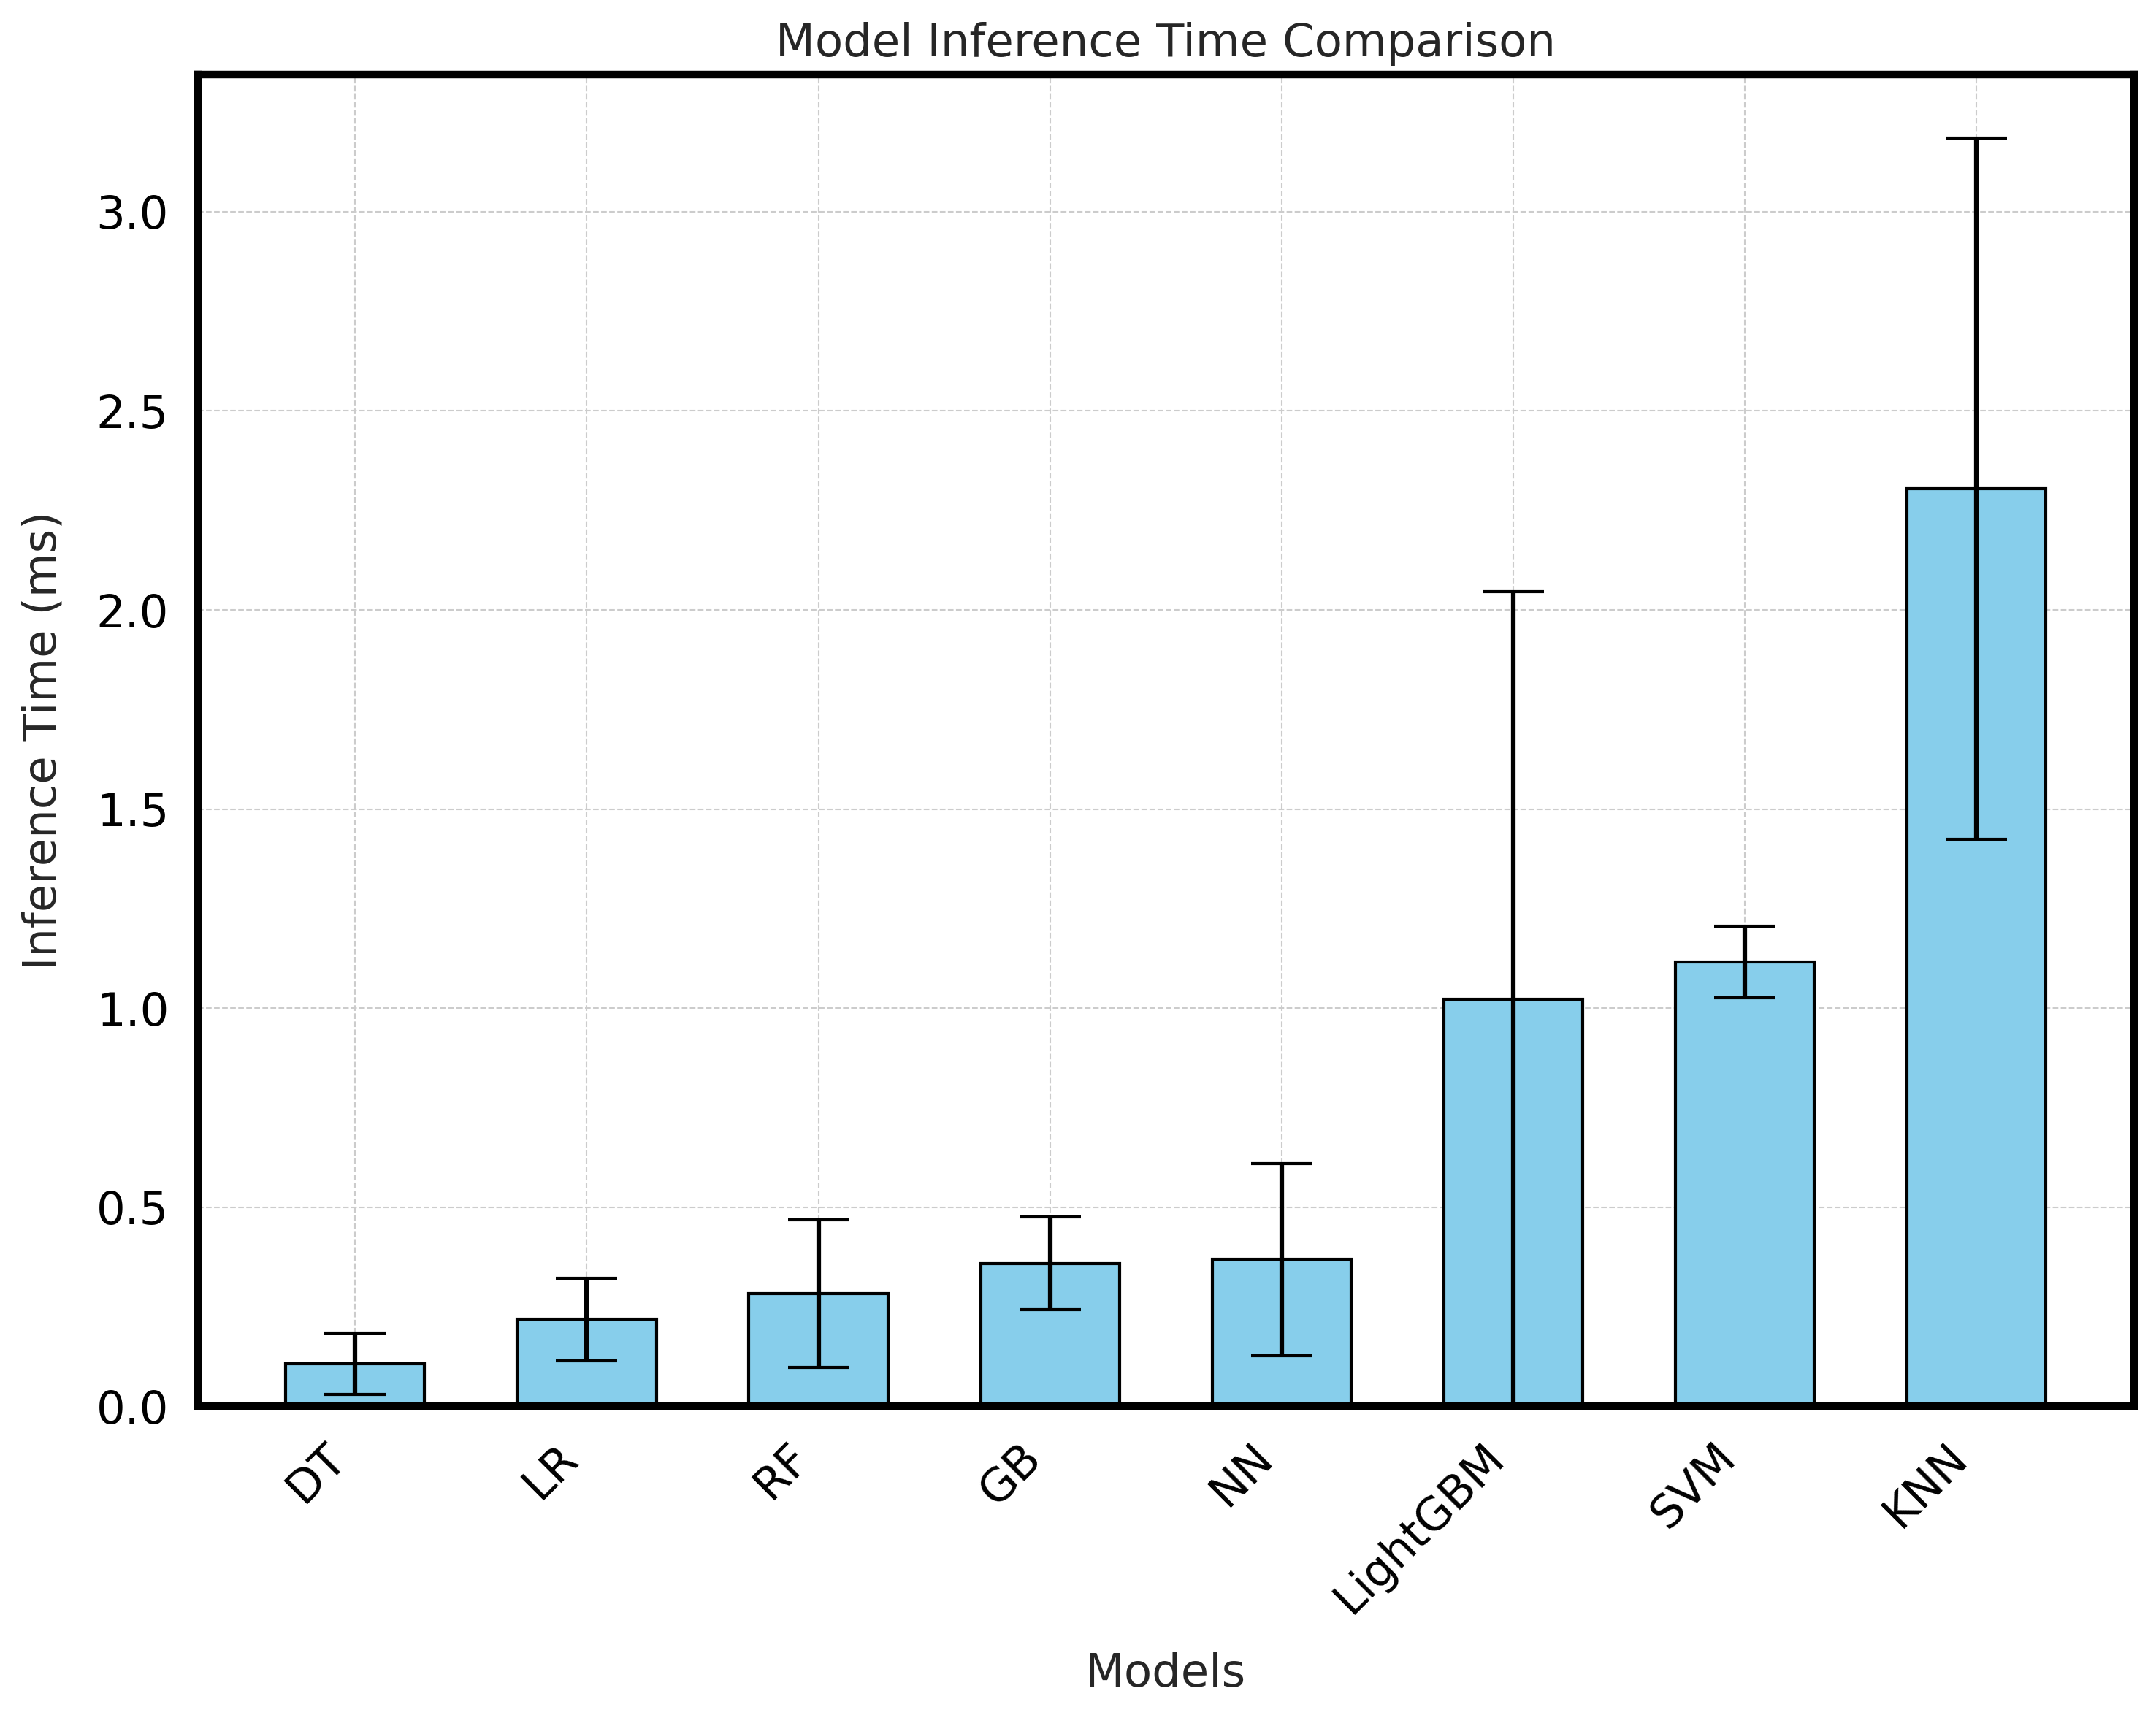

In [88]:
# Remove the models "AdaBoost" and "GB"
inference_times.pop("AdaBoost", None)
inference_times.pop("BalancedRandomForest", None)
inference_times.pop("RUSBoostClassifier", None)
inference_times.pop("XGBoost", None)
# Extracting data for plotting
model_names = list(inference_times.keys())

plot_inference_time(model_names, inference_times)
save_fig("inference_time_selected")